## lire le document de quelle type il est et si cest une image ou contien du text dans sont code

In [1]:
from __future__ import annotations

import csv
import os
import re
import zipfile
import xml.etree.ElementTree as ET
from dataclasses import dataclass
from typing import Optional, Sequence, Union, List, Dict, Any


# Saisie possible:
# INPUT_FILE = "a.pdf, b.docx, c.png"
# INPUT_FILE = ["a.pdf", "b.docx", "c.png"]
INPUT_FILE: Optional[Union[str, Sequence[str]]] = (
    "testexcel.xlsx, testword.docx, image2tab.webp, contras-14page.pdf, signettab.png"
)

# Heuristiques
MIN_CHARS_OFFICE = 1     # 1 caractère => "text"
MIN_CHARS_PDF = 30       # seuil de texte extrait
PDF_MAX_PAGES = 3        # on teste les N premières pages

# Dossiers de recherche si un nom est donné sans chemin (utile en notebook)
SEARCH_DIRS = [
    os.getcwd(),
    "/mnt/data",  # utile dans l'environnement ChatGPT
]


@dataclass(frozen=True)
class FileType:
    ext: str
    mime: str
    label: str


# ----------------- input parsing -----------------

def normalize_input_files(x: Optional[Union[str, Sequence[str]]]) -> List[str]:
    """Retourne toujours une liste. Supporte une string avec virgules (CSV)."""
    if x is None:
        return []
    if isinstance(x, str):
        s = x.strip()
        if not s:
            return []
        if "," not in s:
            return [s]
        parts = next(csv.reader([s], skipinitialspace=True))
        return [p.strip() for p in parts if p.strip()]
    return [str(p).strip() for p in x if str(p).strip()]


def resolve_path(p: str) -> Optional[str]:
    """
    Résout un chemin:
    - si p existe tel quel -> retourne p
    - sinon essaie SEARCH_DIRS + basename(p)
    - sinon retourne None (introuvable)
    """
    p = os.path.expandvars(os.path.expanduser(p.strip()))
    if os.path.exists(p):
        return p

    base = os.path.basename(p)
    for d in SEARCH_DIRS:
        alt = os.path.join(d, base)
        if os.path.exists(alt):
            return alt

    return None


# ----------------- format detection -----------------

def _read_head(path: str, n: int = 16384) -> bytes:
    with open(path, "rb") as f:
        return f.read(n)


def detect_path_type(path: str) -> FileType:
    head = _read_head(path)

    if head.startswith(b"%PDF-"):
        return FileType(".pdf", "application/pdf", "PDF document")

    if head.startswith(b"II*\x00") or head.startswith(b"MM\x00*"):
        return FileType(".tif", "image/tiff", "TIFF image")

    if head.startswith(b"\x89PNG\r\n\x1a\n"):
        return FileType(".png", "image/png", "PNG image")

    if head.startswith(b"\xff\xd8\xff"):
        return FileType(".jpg", "image/jpeg", "JPEG image")

    if len(head) >= 12 and head.startswith(b"RIFF") and head[8:12] == b"WEBP":
        return FileType(".webp", "image/webp", "WEBP image")

    # ZIP containers (DOCX/XLSX/PPTX/ODT/ODS/ODP/EPUB/ZIP)
    if head.startswith(b"PK\x03\x04") or head.startswith(b"PK\x05\x06") or head.startswith(b"PK\x07\x08"):
        try:
            with zipfile.ZipFile(path, "r") as z:
                names = set(z.namelist())

                # EPUB
                if "mimetype" in names and "META-INF/container.xml" in names:
                    try:
                        mt = z.read("mimetype")[:64].decode("ascii", errors="ignore").strip()
                    except Exception:
                        mt = ""
                    if mt == "application/epub+zip":
                        return FileType(".epub", "application/epub+zip", "EPUB eBook")

                # Office OpenXML
                if "word/document.xml" in names:
                    return FileType(".docx", "application/vnd.openxmlformats-officedocument.wordprocessingml.document", "Word document (DOCX)")
                if "xl/workbook.xml" in names:
                    return FileType(".xlsx", "application/vnd.openxmlformats-officedocument.spreadsheetml.sheet", "Excel workbook (XLSX)")
                if "ppt/presentation.xml" in names:
                    return FileType(".pptx", "application/vnd.openxmlformats-officedocument.presentationml.presentation", "PowerPoint presentation (PPTX)")

                # OpenDocument
                if "content.xml" in names and "META-INF/manifest.xml" in names:
                    mt = ""
                    try:
                        if "mimetype" in names:
                            mt = z.read("mimetype")[:128].decode("ascii", errors="ignore").strip()
                    except Exception:
                        mt = ""
                    if mt == "application/vnd.oasis.opendocument.text":
                        return FileType(".odt", mt, "OpenDocument Text (ODT)")
                    if mt == "application/vnd.oasis.opendocument.spreadsheet":
                        return FileType(".ods", mt, "OpenDocument Spreadsheet (ODS)")
                    if mt == "application/vnd.oasis.opendocument.presentation":
                        return FileType(".odp", mt, "OpenDocument Presentation (ODP)")
                    return FileType(".odf", "application/zip", "OpenDocument container")

        except Exception:
            pass

        return FileType(".zip", "application/zip", "ZIP archive/container")

    # Ancien Office (OLE2)
    if head.startswith(b"\xD0\xCF\x11\xE0\xA1\xB1\x1A\xE1"):
        return FileType(".ole", "application/x-ole-storage", "OLE2 container (old Office)")

    return FileType("", "application/octet-stream", "Unknown / binary")


# ----------------- text vs image_only -----------------

def _xml_text_len(xml_bytes: bytes) -> int:
    """Compte du texte dans du XML (éléments + fallback simple)."""
    try:
        root = ET.fromstring(xml_bytes)
        total = 0
        for elem in root.iter():
            if elem.text and elem.text.strip():
                total += len(elem.text.strip())
        return total
    except Exception:
        s = re.sub(rb"<[^>]+>", b" ", xml_bytes)
        return len(re.sub(rb"\s+", b" ", s).strip())


def _zip_has_text(path: str, ext: str) -> bool:
    """
    DOCX/XLSX/PPTX/ODT/ODS/ODP/EPUB
    True si on trouve au moins MIN_CHARS_OFFICE caractères.
    """
    try:
        with zipfile.ZipFile(path, "r") as z:
            names = z.namelist()

            if ext == ".docx":
                total = 0
                # corps
                if "word/document.xml" in names:
                    total += _xml_text_len(z.read("word/document.xml"))
                # headers/footers (souvent du texte “isolé”)
                for nm in names:
                    if nm.startswith("word/header") and nm.endswith(".xml"):
                        total += _xml_text_len(z.read(nm))
                    if nm.startswith("word/footer") and nm.endswith(".xml"):
                        total += _xml_text_len(z.read(nm))
                    if total >= MIN_CHARS_OFFICE:
                        break
                return total >= MIN_CHARS_OFFICE

            if ext == ".xlsx":
                total = 0
                if "xl/sharedStrings.xml" in names:
                    total += _xml_text_len(z.read("xl/sharedStrings.xml"))
                if total < MIN_CHARS_OFFICE:
                    for nm in names:
                        if nm.startswith("xl/worksheets/") and nm.endswith(".xml"):
                            total += _xml_text_len(z.read(nm))
                            if total >= MIN_CHARS_OFFICE:
                                break
                return total >= MIN_CHARS_OFFICE

            if ext == ".pptx":
                total = 0
                for nm in names:
                    if nm.startswith("ppt/slides/") and nm.endswith(".xml"):
                        total += _xml_text_len(z.read(nm))
                        if total >= MIN_CHARS_OFFICE:
                            break
                return total >= MIN_CHARS_OFFICE

            if ext in {".odt", ".ods", ".odp"}:
                if "content.xml" in names:
                    return _xml_text_len(z.read("content.xml")) >= MIN_CHARS_OFFICE
                return False

            if ext == ".epub":
                total = 0
                for nm in names:
                    low = nm.lower()
                    if low.endswith((".xhtml", ".html", ".htm")):
                        try:
                            b = z.read(nm)
                        except Exception:
                            continue
                        s = re.sub(rb"<[^>]+>", b" ", b)
                        total += len(re.sub(rb"\s+", b" ", s).strip())
                        if total >= MIN_CHARS_OFFICE:
                            break
                return total >= MIN_CHARS_OFFICE

    except Exception:
        return False

    return False


def _get_pdf_reader():
    """Retourne PdfReader depuis pypdf ou PyPDF2, ou None si indisponible."""
    try:
        from pypdf import PdfReader  # type: ignore
        return PdfReader
    except ImportError:
        try:
            from PyPDF2 import PdfReader  # type: ignore
            return PdfReader
        except ImportError:
            return None


def _pdf_has_text(path: str) -> bool:
    """
    PDF:
    - True si extract_text() produit assez de caractères, OU si fonts / opérateurs texte présents.
    - Si aucune lib PDF n'est dispo: fallback binaire (cherche /Font ou opérateurs BT/Tj).
    """
    PdfReader = _get_pdf_reader()
    if PdfReader is None:
        # fallback binaire: moins fiable, mais évite de renvoyer faux systématique
        try:
            with open(path, "rb") as f:
                data = f.read(2_000_000)  # 2MB max
            if b"/Font" in data:
                return True
            if b"BT" in data and (b"Tj" in data or b"TJ" in data):
                return True
        except Exception:
            pass
        return False

    try:
        reader = PdfReader(path)
        pages = reader.pages[: max(1, PDF_MAX_PAGES)]

        extracted_score = 0
        saw_font = False
        saw_text_ops = False

        for page in pages:
            # 1) extraction texte
            txt = page.extract_text() or ""
            extracted_score += len("".join(txt.split()))
            if extracted_score >= MIN_CHARS_PDF:
                return True

            # 2) fonts dans resources
            try:
                res = page.get("/Resources") or {}
                font = res.get("/Font")
                if font:
                    saw_font = True
            except Exception:
                pass

            # 3) opérateurs texte dans stream
            try:
                contents = page.get_contents()
                if contents is None:
                    continue
                if hasattr(contents, "get_data"):
                    data = contents.get_data()
                else:
                    data = b"".join(c.get_data() for c in contents)  # type: ignore
                if b"BT" in data and (b"Tj" in data or b"TJ" in data):
                    saw_text_ops = True
            except Exception:
                pass

        return saw_font or saw_text_ops

    except Exception:
        return False


def content_kind_two_states(path: str, ftype: FileType) -> str:
    """Retourne seulement: 'text' ou 'image_only'."""
    ext = ftype.ext.lower()

    # Images => image_only
    if ext in {".png", ".jpg", ".jpeg", ".webp", ".tif", ".tiff", ".bmp", ".ico"}:
        return "image_only"

    # PDF
    if ext == ".pdf":
        return "text" if _pdf_has_text(path) else "image_only"

    # Formats texte compressés (Office/ODF/EPUB)
    if ext in {".docx", ".xlsx", ".pptx", ".odt", ".ods", ".odp", ".epub"}:
        return "text" if _zip_has_text(path, ext) else "image_only"

    # Tout le reste => image_only (car tu veux 2 états)
    return "image_only"


def analyze_many_two_states(input_file: Optional[Union[str, Sequence[str]]]) -> List[Dict[str, Any]]:
    """
    Sortie:
      [{"path": ..., "ext": ..., "mime": ..., "label": ..., "content": "text|image_only"}, ...]
    Ignore les fichiers introuvables.
    """
    raw_paths = normalize_input_files(input_file)
    out: List[Dict[str, Any]] = []

    for raw in raw_paths:
        p = resolve_path(raw)
        if p is None:
            continue

        ft = detect_path_type(p)
        out.append({
            "path": p,
            "ext": ft.ext,
            "mime": ft.mime,
            "label": ft.label,
            "content": content_kind_two_states(p, ft),
        })

    return out


# Test
analyze_many_two_states(INPUT_FILE)


[{'path': 'testexcel.xlsx',
  'ext': '.xlsx',
  'mime': 'application/vnd.openxmlformats-officedocument.spreadsheetml.sheet',
  'label': 'Excel workbook (XLSX)',
  'content': 'text'},
 {'path': 'testword.docx',
  'ext': '.docx',
  'mime': 'application/vnd.openxmlformats-officedocument.wordprocessingml.document',
  'label': 'Word document (DOCX)',
  'content': 'text'},
 {'path': 'image2tab.webp',
  'ext': '.webp',
  'mime': 'image/webp',
  'label': 'WEBP image',
  'content': 'image_only'},
 {'path': 'contras-14page.pdf',
  'ext': '.pdf',
  'mime': 'application/pdf',
  'label': 'PDF document',
  'content': 'text'},
 {'path': 'signettab.png',
  'ext': '.png',
  'mime': 'image/png',
  'label': 'PNG image',
  'content': 'image_only'}]

### si image faire passer sur un pretraitemetn lamelirer sinon un document avce text dans sont code source aallors pass

[skip] content='text' -> c:\Users\moura\OneDrive\Bureau\DMS\test\testexcel.xlsx
[skip] content='text' -> c:\Users\moura\OneDrive\Bureau\DMS\test\testword.docx
[skip] content='text' -> c:\Users\moura\OneDrive\Bureau\DMS\test\contras-14page.pdf


[info] Using INPUT_FILE=c:\Users\moura\OneDrive\Bureau\DMS\test\image2tab.webp
[info] Using INPUT_FILE=c:\Users\moura\OneDrive\Bureau\DMS\test\signettab.png


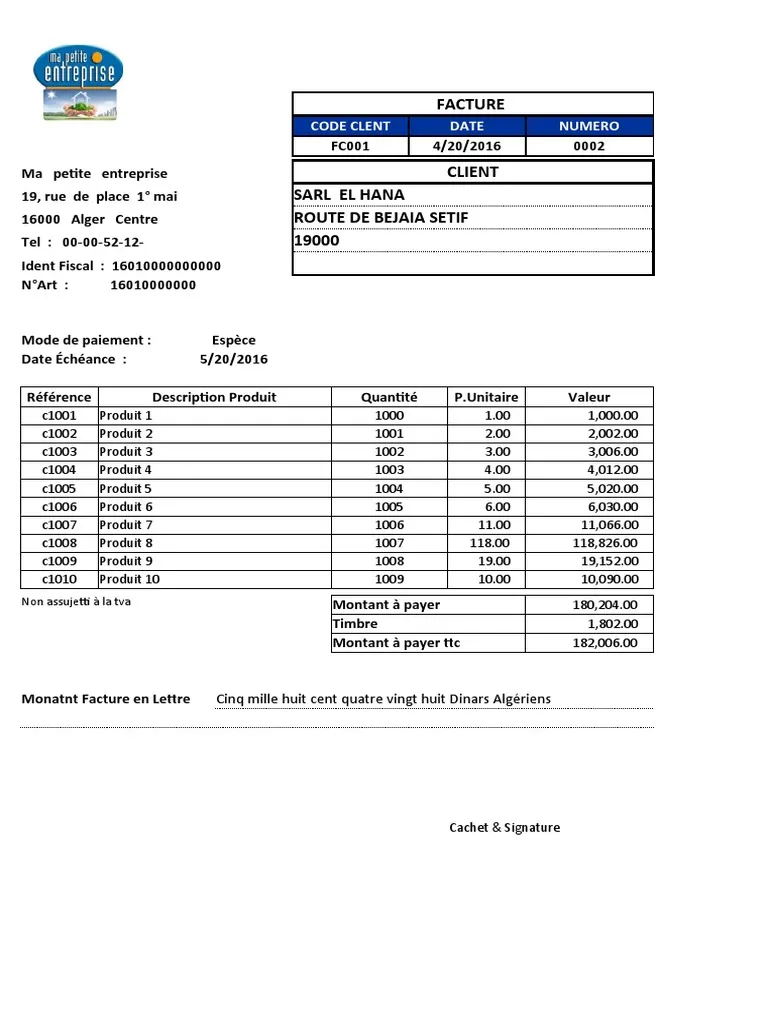

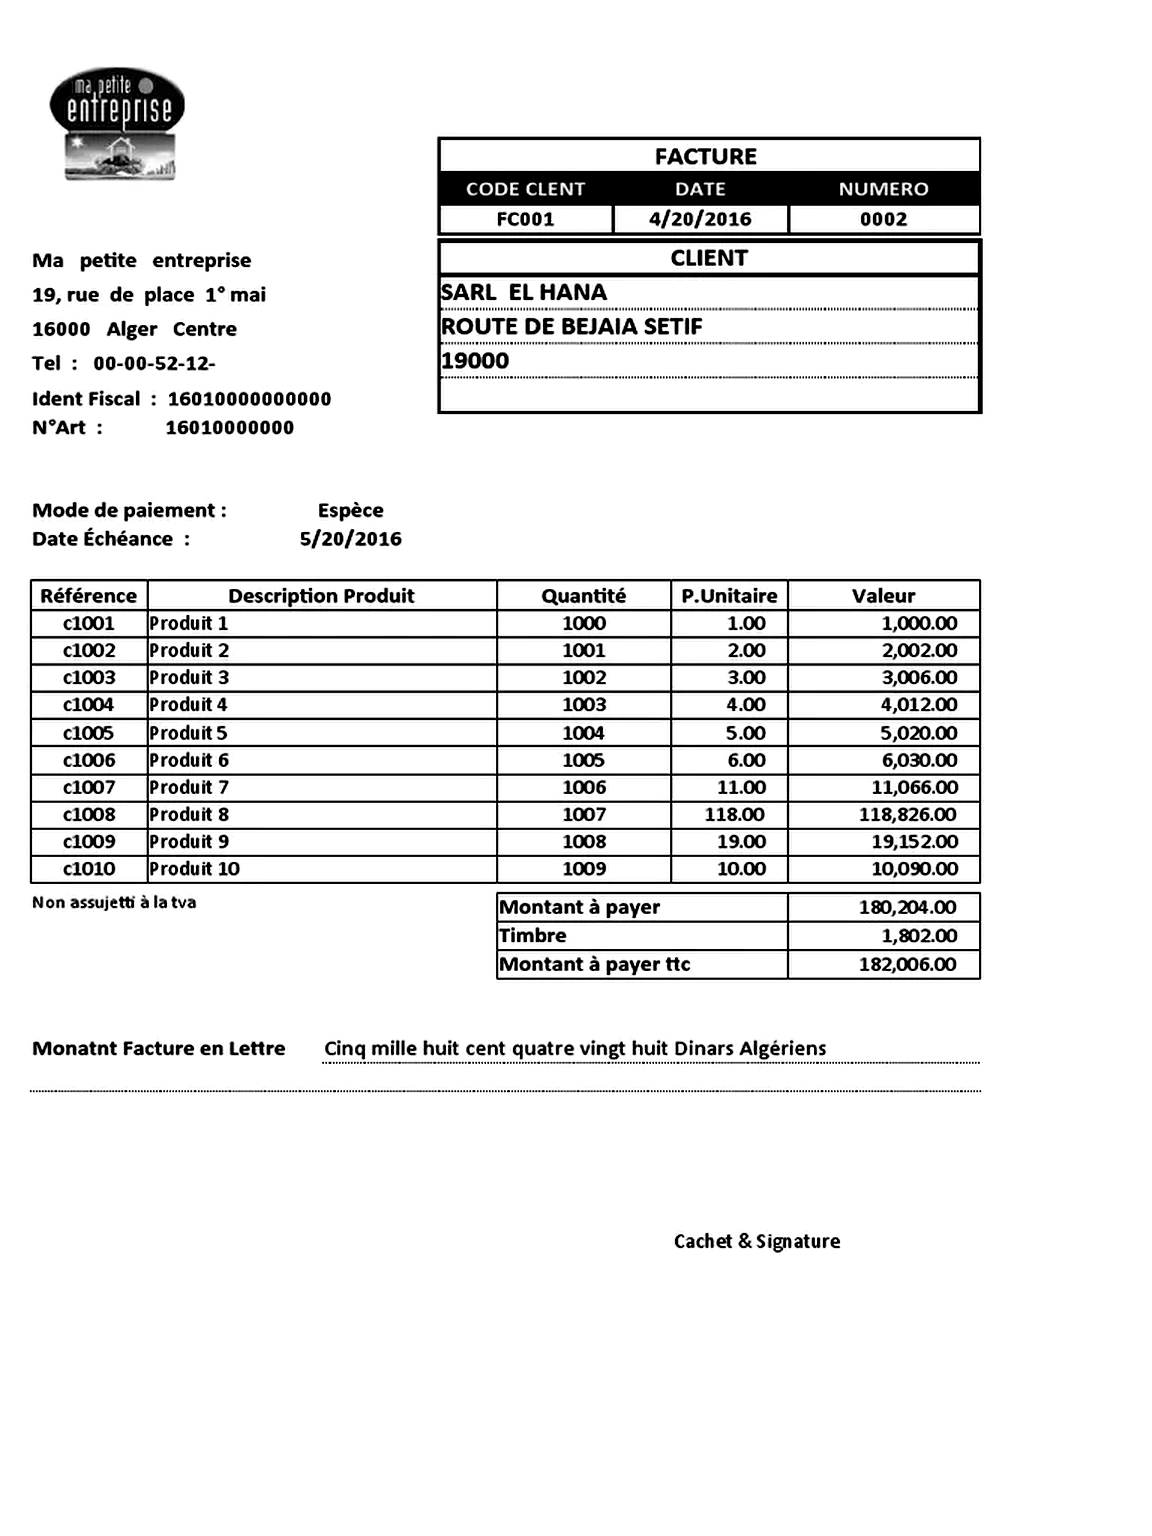

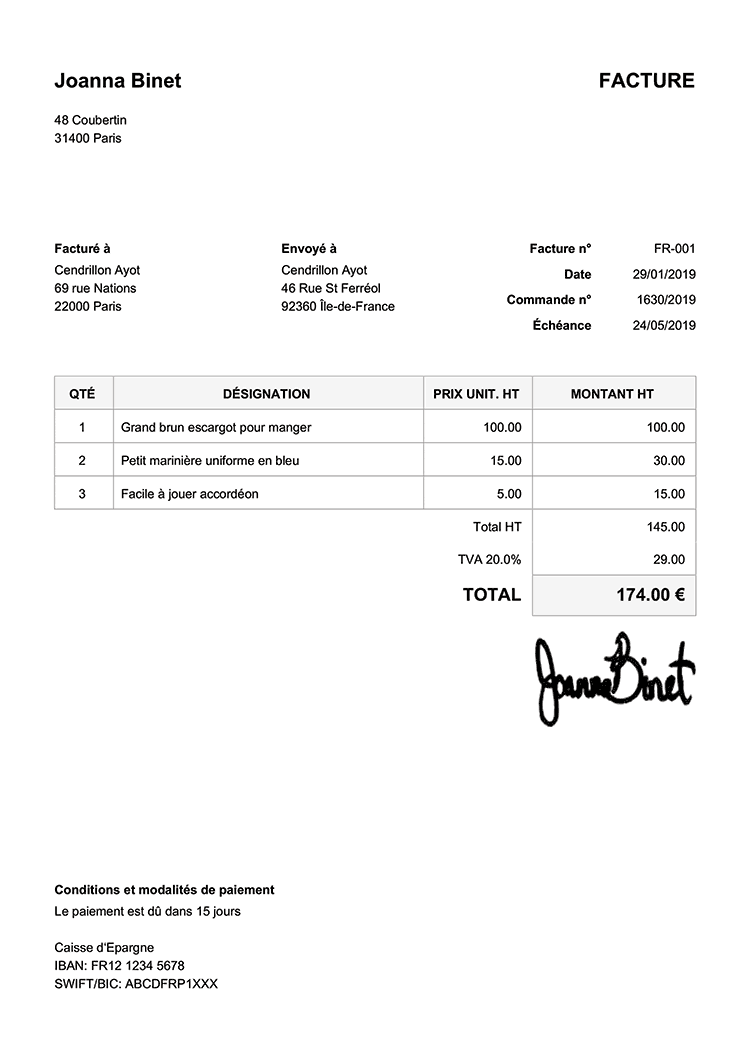

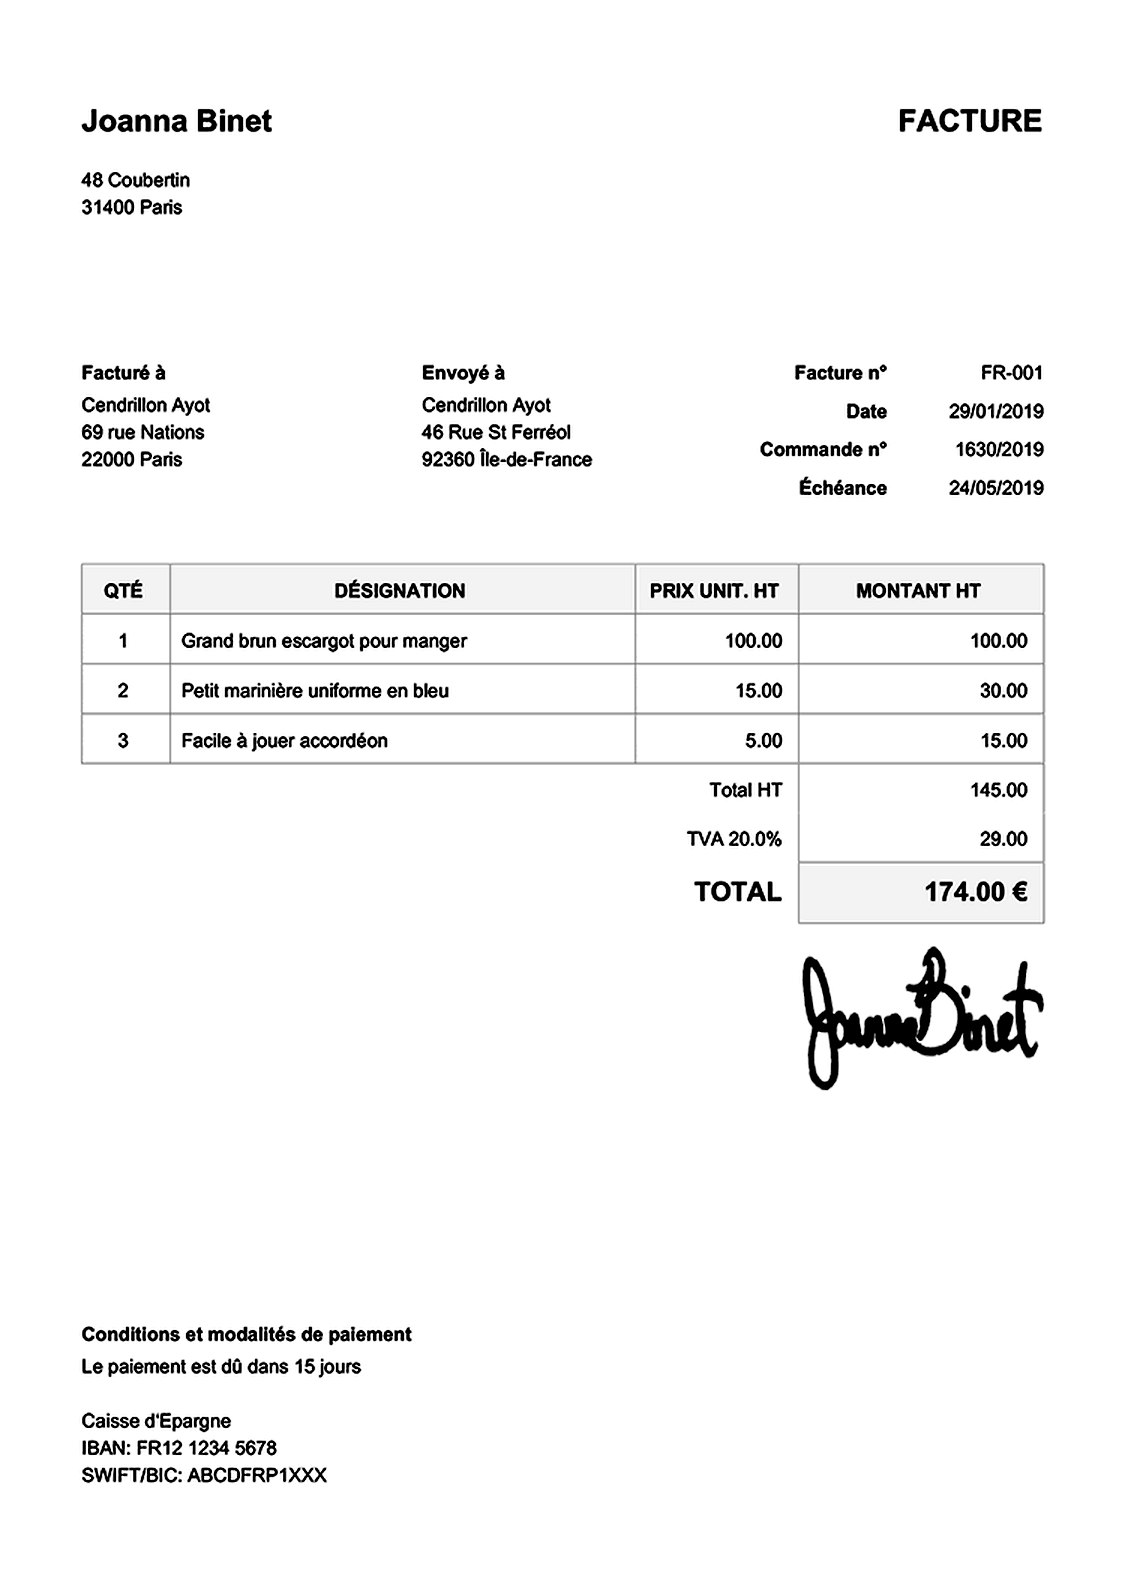

In [2]:
from __future__ import annotations

import csv
import os
import re
import zipfile
import xml.etree.ElementTree as ET
from dataclasses import dataclass
from typing import Optional, Sequence, Union, List

import argparse
import sys
from pathlib import Path
from typing import Iterable, List, Optional, Tuple

import pytesseract
from PIL import Image, ImageEnhance, ImageFilter, ImageOps


try:
    import numpy as np  # type: ignore
except ImportError:  # pragma: no cover
    np = None

try:
    SCRIPT_DIR = Path(__file__).resolve().parent
except NameError:
    # In notebooks __file__ is undefined; fall back to current working directory.
    SCRIPT_DIR = Path.cwd()

DEFAULT_LANG = "fra"
DEFAULT_CONTRAST = 1.5
DEFAULT_SHARPNESS = 1.2
DEFAULT_BRIGHTNESS = 1.0
DEFAULT_UPSCALE = 1.5
DEFAULT_DPI = 300

# Heuristiques
MIN_CHARS_OFFICE = 1
MIN_CHARS_PDF = 30
PDF_MAX_PAGES = 3
SEARCH_DIRS = [os.getcwd(), "/mnt/data"]  # utile en notebook


@dataclass(frozen=True)
class FileType:
    ext: str
    mime: str
    label: str


def _read_head(path: str, n: int = 16384) -> bytes:
    with open(path, "rb") as f:
        return f.read(n)


def normalize_input_files(x: Optional[Union[str, Sequence[str]]]) -> List[str]:
    if x is None:
        return []
    if isinstance(x, str):
        s = x.strip()
        if not s:
            return []
        if "," not in s: 
            return [s]
        parts = next(csv.reader([s], skipinitialspace=True))
        return [p.strip() for p in parts if p.strip()]
    return [str(p).strip() for p in x if str(p).strip()]


def resolve_path(p: str) -> Optional[str]:
    p = os.path.expandvars(os.path.expanduser(p.strip()))
    if os.path.exists(p):
        return os.path.abspath(p)

    base = os.path.basename(p)
    for d in SEARCH_DIRS:
        alt = os.path.join(d, base)
        if os.path.exists(alt):
            return os.path.abspath(alt)

    return None


def detect_path_type(path: str) -> FileType:
    head = _read_head(path)

    if head.startswith(b"%PDF-"):
        return FileType(".pdf", "application/pdf", "PDF document")

    if head.startswith(b"II*\x00") or head.startswith(b"MM\x00*"):
        return FileType(".tif", "image/tiff", "TIFF image")

    if head.startswith(b"\x89PNG\r\n\x1a\n"):
        return FileType(".png", "image/png", "PNG image")

    if head.startswith(b"\xff\xd8\xff"):
        return FileType(".jpg", "image/jpeg", "JPEG image")

    if len(head) >= 12 and head.startswith(b"RIFF") and head[8:12] == b"WEBP":
        return FileType(".webp", "image/webp", "WEBP image")

    if head.startswith(b"PK\x03\x04") or head.startswith(b"PK\x05\x06") or head.startswith(b"PK\x07\x08"):
        try:
            with zipfile.ZipFile(path, "r") as z:
                names = set(z.namelist())

                if "mimetype" in names and "META-INF/container.xml" in names:
                    try:
                        mt = z.read("mimetype")[:64].decode("ascii", errors="ignore").strip()
                    except Exception:
                        mt = ""
                    if mt == "application/epub+zip":
                        return FileType(".epub", "application/epub+zip", "EPUB eBook")

                if "word/document.xml" in names:
                    return FileType(".docx", "application/vnd.openxmlformats-officedocument.wordprocessingml.document", "Word document (DOCX)")
                if "xl/workbook.xml" in names:
                    return FileType(".xlsx", "application/vnd.openxmlformats-officedocument.spreadsheetml.sheet", "Excel workbook (XLSX)")
                if "ppt/presentation.xml" in names:
                    return FileType(".pptx", "application/vnd.openxmlformats-officedocument.presentationml.presentation", "PowerPoint presentation (PPTX)")

                if "content.xml" in names and "META-INF/manifest.xml" in names:
                    mt = ""
                    try:
                        if "mimetype" in names:
                            mt = z.read("mimetype")[:128].decode("ascii", errors="ignore").strip()
                    except Exception:
                        mt = ""
                    if mt == "application/vnd.oasis.opendocument.text":
                        return FileType(".odt", mt, "OpenDocument Text (ODT)")
                    if mt == "application/vnd.oasis.opendocument.spreadsheet":
                        return FileType(".ods", mt, "OpenDocument Spreadsheet (ODS)")
                    if mt == "application/vnd.oasis.opendocument.presentation":
                        return FileType(".odp", mt, "OpenDocument Presentation (ODP)")
                    return FileType(".odf", "application/zip", "OpenDocument container")
        except Exception:
            pass

        return FileType(".zip", "application/zip", "ZIP archive/container")

    if head.startswith(b"\xD0\xCF\x11\xE0\xA1\xB1\x1A\xE1"):
        return FileType(".ole", "application/x-ole-storage", "OLE2 container (old Office)")

    return FileType("", "application/octet-stream", "Unknown / binary")


def _xml_text_len(xml_bytes: bytes) -> int:
    try:
        root = ET.fromstring(xml_bytes)
        total = 0
        for elem in root.iter():
            if elem.text and elem.text.strip():
                total += len(elem.text.strip())
        return total
    except Exception:
        s = re.sub(rb"<[^>]+>", b" ", xml_bytes)
        return len(re.sub(rb"\s+", b" ", s).strip())


def _zip_has_text(path: str, ext: str) -> bool:
    try:
        with zipfile.ZipFile(path, "r") as z:
            names = z.namelist()

            if ext == ".docx":
                total = 0
                if "word/document.xml" in names:
                    total += _xml_text_len(z.read("word/document.xml"))
                for nm in names:
                    if nm.startswith("word/header") and nm.endswith(".xml"):
                        total += _xml_text_len(z.read(nm))
                    if nm.startswith("word/footer") and nm.endswith(".xml"):
                        total += _xml_text_len(z.read(nm))
                    if total >= MIN_CHARS_OFFICE:
                        break
                return total >= MIN_CHARS_OFFICE

            if ext == ".xlsx":
                total = 0
                if "xl/sharedStrings.xml" in names:
                    total += _xml_text_len(z.read("xl/sharedStrings.xml"))
                if total < MIN_CHARS_OFFICE:
                    for nm in names:
                        if nm.startswith("xl/worksheets/") and nm.endswith(".xml"):
                            total += _xml_text_len(z.read(nm))
                            if total >= MIN_CHARS_OFFICE:
                                break
                return total >= MIN_CHARS_OFFICE

            if ext == ".pptx":
                total = 0
                for nm in names:
                    if nm.startswith("ppt/slides/") and nm.endswith(".xml"):
                        total += _xml_text_len(z.read(nm))
                        if total >= MIN_CHARS_OFFICE:
                            break
                return total >= MIN_CHARS_OFFICE

            if ext in {".odt", ".ods", ".odp"}:
                return ("content.xml" in names) and (_xml_text_len(z.read("content.xml")) >= MIN_CHARS_OFFICE)

            if ext == ".epub":
                total = 0
                for nm in names:
                    low = nm.lower()
                    if low.endswith((".xhtml", ".html", ".htm")):
                        try:
                            b = z.read(nm)
                        except Exception:
                            continue
                        s = re.sub(rb"<[^>]+>", b" ", b)
                        total += len(re.sub(rb"\s+", b" ", s).strip())
                        if total >= MIN_CHARS_OFFICE:
                            break
                return total >= MIN_CHARS_OFFICE

    except Exception:
        return False

    return False


def _get_pdf_reader():
    try:
        from pypdf import PdfReader  # type: ignore
        return PdfReader
    except ImportError:
        try:
            from PyPDF2 import PdfReader  # type: ignore
            return PdfReader
        except ImportError:
            return None


def _pdf_has_text(path: str) -> bool:
    PdfReader = _get_pdf_reader()

    if PdfReader is None:
        try:
            with open(path, "rb") as f:
                data = f.read(2_000_000)
            if b"/Font" in data:
                return True
            if b"BT" in data and (b"Tj" in data or b"TJ" in data):
                return True
        except Exception:
            pass
        return False

    try:
        reader = PdfReader(path)
        pages = reader.pages[: max(1, PDF_MAX_PAGES)]
        extracted_score = 0

        for page in pages:
            txt = page.extract_text() or ""
            extracted_score += len("".join(txt.split()))
            if extracted_score >= MIN_CHARS_PDF:
                return True
        return False
    except Exception:
        return False


def content_kind_two_states(path: str, ftype: FileType) -> str:
    ext = ftype.ext.lower()

    if ext in {".png", ".jpg", ".jpeg", ".webp", ".tif", ".tiff", ".bmp", ".ico"}:
        return "image_only"

    if ext == ".pdf":
        return "text" if _pdf_has_text(path) else "image_only"

    if ext in {".docx", ".xlsx", ".pptx", ".odt", ".ods", ".odp", ".epub"}:
        return "text" if _zip_has_text(path, ext) else "image_only"

    return "image_only"


# --------- ROUTAGE ---------
ORIGINAL_INPUT_FILE = globals().get("INPUT_FILE", None)
_raw_items = normalize_input_files(ORIGINAL_INPUT_FILE)

IMAGE_ONLY_FILES: List[str] = []
TEXT_FILES: List[str] = []
MISSING_FILES: List[str] = []

for item in _raw_items:
    p = resolve_path(item)
    if p is None:
        MISSING_FILES.append(item)
        continue

    ft = detect_path_type(p)
    kind = content_kind_two_states(p, ft)

    if kind == "image_only":
        IMAGE_ONLY_FILES.append(p)
    else:
        TEXT_FILES.append(p)
        print(f"[skip] content='text' -> {p}")

# IMPORTANT: ton code OCR (cellule suivante) reste inchangé, il lira INPUT_FILE ici
INPUT_FILE = IMAGE_ONLY_FILES

if MISSING_FILES:
    print("[missing] fichiers introuvables:")
    for m in MISSING_FILES:
        print(" -", m)








SHOW_PREPROCESSED = True   #/////////////////////////////////////////////////////////////////////////////////////////////////////////////////


@dataclass
class EnhanceOptions:
    contrast: float = DEFAULT_CONTRAST
    sharpness: float = DEFAULT_SHARPNESS
    brightness: float = DEFAULT_BRIGHTNESS
    upscale: float = DEFAULT_UPSCALE
    gamma: Optional[float] = None  # gamma correction; <1 brightens darks, >1 darkens
    pad: int = 0  # pixels to pad around the image
    median: Optional[int] = None  # kernel size for median filter (odd int, e.g., 3)
    unsharp_radius: Optional[float] = None  # e.g., 1.0
    unsharp_percent: int = 150
    invert: bool = False
    autocontrast_cutoff: Optional[int] = None  # 0-100; percentage to clip for autocontrast
    equalize: bool = False  # histogram equalization
    auto_rotate: bool = False  # attempt orientation detection + rotate
    otsu: bool = False  # auto-threshold with Otsu (requires numpy)
    threshold: Optional[int] = None  # 0-255; if set, applies a binary threshold


def build_config(
    oem: Optional[int],
    psm: Optional[int],
    base_flags: Iterable[str],
    dpi: Optional[int],
    tessdata_dir: Optional[Path],
    user_words: Optional[Path],
    user_patterns: Optional[Path],
) -> str:
    parts: List[str] = []
    if oem is not None:
        parts.append(f"--oem {oem}")
    if psm is not None:
        parts.append(f"--psm {psm}")
    if dpi is not None:
        parts.append(f"--dpi {dpi}")
    if tessdata_dir is not None:
        parts.append(f'--tessdata-dir "{tessdata_dir}"')
    if user_words is not None:
        parts.append(f'--user-words "{user_words}"')
    if user_patterns is not None:
        parts.append(f'--user-patterns "{user_patterns}"')
    parts.extend(base_flags)
    return " ".join(parts)


def ensure_environment(lang: str) -> None:
    try:
        _ = pytesseract.get_tesseract_version()
    except pytesseract.TesseractNotFoundError:
        sys.exit("Tesseract binary not found on PATH. Install it and its language data.")
    if lang:
        try:
            available = set(pytesseract.get_languages(config=""))
            requested = set(lang.split("+"))
            missing = requested - available
            if missing:
                print(
                    f"Warning: missing languages: {', '.join(sorted(missing))}. "
                    f"Available: {', '.join(sorted(available))}",
                    file=sys.stderr,
                )
        except pytesseract.TesseractError:
            pass


def auto_rotate_if_needed(img: Image.Image, enhance: EnhanceOptions) -> Image.Image:
    if not enhance.auto_rotate:
        return img
    try:
        osd = pytesseract.image_to_osd(img)
        angle = None
        for line in osd.splitlines():
            if line.lower().startswith("rotate:"):
                try:
                    angle = int(line.split(":")[1].strip())
                except ValueError:
                    angle = None
                break
        if angle is not None and angle % 360 != 0:
            return img.rotate(-angle, expand=True)
    except Exception:
        pass
    return img


def preprocess_image(image: Image.Image, enhance: EnhanceOptions) -> Image.Image:
    img = image.convert("L")
    img = auto_rotate_if_needed(img, enhance)

    if enhance.invert:
        img = ImageOps.invert(img)

    if enhance.pad and enhance.pad > 0:
        img = ImageOps.expand(img, border=enhance.pad, fill=255)

    if enhance.autocontrast_cutoff is not None:
        cutoff = max(0, min(100, enhance.autocontrast_cutoff))
        img = ImageOps.autocontrast(img, cutoff=cutoff)

    if enhance.equalize:
        img = ImageOps.equalize(img)

    if enhance.upscale and enhance.upscale != 1.0:
        w, h = img.size
        img = img.resize((int(w * enhance.upscale), int(h * enhance.upscale)), Image.LANCZOS)

    if enhance.gamma and enhance.gamma > 0:
        inv_gamma = 1.0 / enhance.gamma
        lut = [pow(x / 255.0, inv_gamma) * 255 for x in range(256)]
        img = img.point(lut)

    if enhance.brightness and enhance.brightness != 1.0:
        img = ImageEnhance.Brightness(img).enhance(enhance.brightness)

    if enhance.contrast and enhance.contrast != 1.0:
        img = ImageEnhance.Contrast(img).enhance(enhance.contrast)

    if enhance.sharpness and enhance.sharpness != 1.0:
        img = ImageEnhance.Sharpness(img).enhance(enhance.sharpness)

    if enhance.unsharp_radius:
        img = img.filter(
            ImageFilter.UnsharpMask(
                radius=enhance.unsharp_radius,
                percent=enhance.unsharp_percent,
                threshold=0,
            )
        )

    if enhance.median and enhance.median > 1 and enhance.median % 2 == 1:
        img = img.filter(ImageFilter.MedianFilter(size=enhance.median))

    if enhance.threshold is not None:
        thr = max(0, min(255, enhance.threshold))
        img = img.point(lambda p, t=thr: 255 if p > t else 0, mode="1").convert("L")
    elif enhance.otsu and np is not None:
        arr = np.array(img, dtype=np.uint8)
        hist, _ = np.histogram(arr, bins=256, range=(0, 256))
        total = arr.size
        sum_total = np.dot(np.arange(256), hist)

        sum_b = 0.0
        w_b = 0.0
        max_var = 0.0
        threshold = 0

        for i in range(256):
            w_b += hist[i]
            if w_b == 0:
                continue
            w_f = total - w_b
            if w_f == 0:
                break
            sum_b += i * hist[i]
            m_b = sum_b / w_b
            m_f = (sum_total - sum_b) / w_f
            var_between = w_b * w_f * (m_b - m_f) ** 2
            if var_between > max_var:
                max_var = var_between
                threshold = i

        img = img.point(lambda p, t=threshold: 255 if p > t else 0, mode="1").convert("L")

    return img


def parse_args(argv: Optional[Iterable[str]] = None) -> argparse.Namespace:
    parser = argparse.ArgumentParser()
    parser.add_argument("-l", "--lang", default=DEFAULT_LANG)
    parser.add_argument("--oem", type=int, choices=range(0, 4), default=None)
    parser.add_argument("--psm", type=int, choices=range(0, 14), default=None)
    parser.add_argument("--dpi", type=int, default=DEFAULT_DPI)
    parser.add_argument("--tessdata-dir", type=Path, default=None)
    parser.add_argument("--user-words", type=Path, default=None)
    parser.add_argument("--user-patterns", type=Path, default=None)
    parser.add_argument("--whitelist", type=str, default=None)
    parser.add_argument("--blacklist", type=str, default=None)

    parser.add_argument("--contrast", type=float, default=DEFAULT_CONTRAST)
    parser.add_argument("--sharpness", type=float, default=DEFAULT_SHARPNESS)
    parser.add_argument("--brightness", type=float, default=DEFAULT_BRIGHTNESS)
    parser.add_argument("--upscale", type=float, default=DEFAULT_UPSCALE)
    parser.add_argument("--gamma", type=float, default=None)
    parser.add_argument("--pad", type=int, default=0)
    parser.add_argument("--threshold", type=int, default=None)
    parser.add_argument("--median", type=int, default=None)
    parser.add_argument("--unsharp-radius", type=float, default=None)
    parser.add_argument("--unsharp-percent", type=int, default=150)
    parser.add_argument("--invert", action="store_true")
    parser.add_argument("--autocontrast-cutoff", type=int, default=None)
    parser.add_argument("--equalize", action="store_true")
    parser.add_argument("--auto-rotate", action="store_true")
    parser.add_argument("--otsu", action="store_true")

    parser.add_argument(
        "--config",
        nargs="*",
        default=[],
        metavar="CFG",
        help="Additional configuration flags passed verbatim to tesseract (e.g., -c foo=bar).",
    )

    return parser.parse_args(list(argv) if argv is not None else [])


#  Exécution Cellule 1 (jusqu’à l’affichage) 

args = parse_args()
ensure_environment(args.lang)

enhance = EnhanceOptions(
    contrast=args.contrast,
    sharpness=args.sharpness,
    brightness=args.brightness,
    upscale=args.upscale,
    gamma=args.gamma,
    pad=args.pad,
    median=args.median,
    unsharp_radius=args.unsharp_radius,
    unsharp_percent=args.unsharp_percent,
    invert=args.invert,
    autocontrast_cutoff=args.autocontrast_cutoff,
    equalize=args.equalize,
    auto_rotate=args.auto_rotate,
    otsu=args.otsu,
    threshold=args.threshold,
)

config_flags: List[str] = list(args.config)

# AJOUTE ÇA :
config_flags.append("-c preserve_interword_spaces=1")

if args.whitelist:
    config_flags.append(f"-c tessedit_char_whitelist={args.whitelist}")
if args.blacklist:
    config_flags.append(f"-c tessedit_char_blacklist={args.blacklist}")


def _normalize_input_files(val):
    if val is None:
        return []
    if isinstance(val, (list, tuple, set)):
        items = list(val)
    else:
        items = [val]

    out = []
    for item in items:
        if item is None:
            continue
        if isinstance(item, Path):
            out.append(str(item))
            continue
        s = str(item).strip()
        if not s:
            continue
        if "," in s:
            parts = [p.strip() for p in s.split(",") if p.strip()]
            out.extend(parts)
        else:
            out.append(s)
    return out

# Backwards-compatible alias (older cell name)
_normalize_input_file = _normalize_input_files

# Safeguard if INPUT_FILE cell not executed yet
INPUT_FILE = globals().get("INPUT_FILE", None)


def _load_images_from_path(path: Path, dpi: int):
    if path.suffix.lower() == ".pdf":
        try:
            from pdf2image import convert_from_path
        except Exception:
            sys.exit(
                "pdf2image is not available. Install it and Poppler to read PDF files."
            )
        try:
            return convert_from_path(str(path), dpi=dpi)
        except Exception as exc:
            sys.exit(f"PDF conversion failed for {path}: {exc}")
    # default: image file (supports multi-page TIFF)
    img = Image.open(path)
    n_frames = getattr(img, "n_frames", 1)
    if n_frames and n_frames > 1:
        images = []
        for i in range(n_frames):
            try:
                img.seek(i)
            except Exception:
                break
            images.append(img.copy())
        return images
    return [img]


input_items = _normalize_input_files(INPUT_FILE)
if not input_items:
    sys.exit("INPUT_FILE is not set. Put your image filename(s) in INPUT_FILE.")

DOCS = []
for item in input_items:
    path = Path(item)
    if not path.is_absolute():
        path = (SCRIPT_DIR / path).resolve()

    if not path.exists():
        sys.exit(f"INPUT_FILE not found: {path}")

    print(f"[info] Using INPUT_FILE={path}", file=sys.stderr)

    dpi_val = int(getattr(args, "dpi", DEFAULT_DPI) or DEFAULT_DPI)
    images = _load_images_from_path(path, dpi=dpi_val)

    if len(images) == 1:
        original = images[0]
        prepped = preprocess_image(original, enhance)
        DOCS.append({"path": path, "original": original, "prepped": prepped})
    else:
        total = len(images)
        for idx, original in enumerate(images, start=1):
            prepped = preprocess_image(original, enhance)
            DOCS.append({
                "path": path,
                "original": original,
                "prepped": prepped,
                "page_index": idx,
                "page_count": total
            })

from IPython.display import display

for doc in DOCS:
    original = doc["original"]
    prepped = doc["prepped"]
    path = doc["path"]

    display(original.convert("RGB") if original.mode not in ("RGB","L") else original)

    if "SHOW_PREPROCESSED" not in globals() or SHOW_PREPROCESSED:
        display(prepped.convert("RGB") if prepped.mode not in ("RGB","L") else prepped)

# Keep globals aligned with the last document for backwards compatibility.
if DOCS:
    path = DOCS[-1]["path"]
    original = DOCS[-1]["original"]
    prepped = DOCS[-1]["prepped"]



### si image passer sur teseract ou document extraire sont contenue apartire de sont contenue code a la fin les deux => input txt

In [ ]:
# NOTE:
# Cette cellule suppose que la cellule précédente a déjà exécuté:
# - la détection/routage (TEXT_FILES / IMAGE_ONLY_FILES / INPUT_FILE)
# - le preprocess + affichage (DOCS avec "prepped")
# Donc ici on fait:
# 1) OCR Tesseract UNIQUEMENT sur DOCS (images -> [info])
# 2) Extraction NATIVE (sans OCR) sur TEXT_FILES (-> [skip] content='text')
#
# Objectif print:
# - 1 seule fois, à la fin
# - affiche: fichier, nb pages, puis texte de chaque page

import uuid
import re
import zipfile
import xml.etree.ElementTree as ET
from pathlib import Path
from typing import List

import pytesseract
from pytesseract import Output

# ==================== Réglage PRINT ====================
# False => aucune sortie pendant OCR/native
# True  => debug pendant extraction (à éviter si tu veux 1 seul print)
PRINT_DURING_EXTRACTION = False

# -------------------- AJOUT MINIMAL (flags tesseract pour espaces/tables) --------------------
if "config_flags" in globals():
    if "-c preserve_interword_spaces=1" not in config_flags:
        config_flags.append("-c preserve_interword_spaces=1")
    if "-c textord_tabfind_find_tables=1" not in config_flags:
        config_flags.append("-c textord_tabfind_find_tables=1")

# -------------------- AJOUT MINIMAL (reconstruction layout via TSV) --------------------
def _median(values):
    values = sorted(values)
    n = len(values)
    if n == 0:
        return None
    mid = n // 2
    if n % 2 == 1:
        return values[mid]
    return (values[mid - 1] + values[mid]) / 2.0

def _estimate_char_metrics(data: dict):
    widths = []
    heights = []
    texts = data.get("text", [])
    confs = data.get("conf", [])
    ws = data.get("width", [])
    hs = data.get("height", [])

    for i, t in enumerate(texts):
        if t is None:
            continue
        s = str(t)
        if not s.strip():
            continue
        try:
            c = float(confs[i])
        except Exception:
            c = 0.0
        if c < 0:
            continue

        w = int(ws[i]) if i < len(ws) else 0
        h = int(hs[i]) if i < len(hs) else 0
        if h > 0:
            heights.append(h)

        L = len(s)
        if w > 0 and L > 0:
            widths.append(w / float(L))

    char_w = _median(widths) or 10.0
    line_h = _median(heights) or 20.0

    if char_w <= 1:
        char_w = 10.0
    if line_h <= 1:
        line_h = 20.0

    return float(char_w), float(line_h)

def _render_layout_from_data(data: dict, img_w: int, img_h: int) -> str:
    char_w, line_h = _estimate_char_metrics(data)
    line_tol = max(6.0, line_h * 0.55)

    items = []
    texts = data.get("text", [])
    confs = data.get("conf", [])
    lefts = data.get("left", [])
    tops = data.get("top", [])
    widths = data.get("width", [])
    heights = data.get("height", [])

    for i, t in enumerate(texts):
        if t is None:
            continue
        s = str(t)
        if not s.strip():
            continue
        try:
            c = float(confs[i])
        except Exception:
            c = 0.0
        if c < 0:
            continue

        l = int(lefts[i]) if i < len(lefts) else 0
        tp = int(tops[i]) if i < len(tops) else 0
        w = int(widths[i]) if i < len(widths) else 0
        h = int(heights[i]) if i < len(heights) else 0

        items.append({"text": s, "left": l, "top": tp, "right": l + w, "height": h})

    items.sort(key=lambda x: (x["top"], x["left"]))

    lines = []
    for it in items:
        placed = False
        if lines and abs(it["top"] - lines[-1]["top"]) <= line_tol:
            lines[-1]["words"].append(it)
            lines[-1]["top"] = min(lines[-1]["top"], it["top"])
            placed = True
        if not placed:
            for ln in reversed(lines):
                if abs(it["top"] - ln["top"]) <= line_tol:
                    ln["words"].append(it)
                    ln["top"] = min(ln["top"], it["top"])
                    placed = True
                    break
        if not placed:
            lines.append({"top": it["top"], "words": [it]})

    lines.sort(key=lambda ln: ln["top"])

    out_lines = []
    prev_row = None

    for ln in lines:
        words = sorted(ln["words"], key=lambda x: x["left"])
        row = int(round(ln["top"] / line_h)) if line_h > 0 else 0
        if prev_row is not None:
            gap = row - prev_row
            if gap > 1:
                for _ in range(gap - 1):
                    out_lines.append("")
        prev_row = row

        line_str = ""
        cursor = 0
        for w in words:
            col = int(round(w["left"] / char_w)) if char_w > 0 else 0
            if col < 0:
                col = 0

            if cursor == 0 and not line_str:
                if col > 0:
                    line_str += " " * col
                    cursor = col
            else:
                needed = col - cursor
                if needed <= 0:
                    needed = 1
                line_str += " " * needed
                cursor += needed

            line_str += w["text"]
            cursor += len(w["text"])

        out_lines.append(line_str)

    return "\n".join(out_lines)

# -------------------- OCR --------------------
config = build_config(
    args.oem,
    args.psm,
    config_flags,
    args.dpi,
    args.tessdata_dir,
    args.user_words,
    args.user_patterns,
)

if "DOCS" not in globals():
    DOCS = []

def _basename(val):
    if val is None:
        return None
    try:
        return Path(val).name
    except Exception:
        s = str(val)
        return s.replace("\\", "/").split("/")[-1]

# If DOCS is a list of pages (legacy), group into document-level objects
if DOCS and isinstance(DOCS[0], dict) and "pages" not in DOCS[0]:
    groups = {}
    for i, page in enumerate(DOCS, start=1):
        raw = str(page.get("path") or "batch")
        key = f"{raw}::p{page.get('page_index') or i}"
        groups.setdefault(key, []).append(page)

    packed = []
    for key, pages in groups.items():
        pages_sorted = sorted(pages, key=lambda p: int(p.get("page_index") or 0)) if pages else []

        source_files = [_basename(p.get("path")) for p in pages_sorted if _basename(p.get("path"))]
        source_files = list(dict.fromkeys(source_files))

        filename = source_files[0] if len(source_files) == 1 else (_basename(key) or "batch")

        doc = {"doc_id": str(uuid.uuid4()), "filename": filename, "source_files": source_files, "pages": []}
        page_index = 1
        for p in pages_sorted:
            idx = int(p.get("page_index") or page_index)
            src_path = p.get("path")
            doc["pages"].append({
                "page_index": idx,
                "image": p.get("original"),
                "prepped": p.get("prepped"),
                "source_path": src_path,
                "source_file": _basename(src_path)
            })
            page_index += 1
        doc["page_count_total"] = len(doc["pages"])
        packed.append(doc)

    DOCS = packed

# Ensure doc-level metadata consistency (even if DOCS already has pages)
for doc in DOCS:
    pages = doc.get("pages", []) or []
    for i, page in enumerate(pages, start=1):
        if not page.get("page_index"):
            page["page_index"] = i
        if not page.get("source_file"):
            src_path = page.get("source_path") or page.get("path")
            page["source_file"] = _basename(src_path)

    doc["page_count_total"] = len(pages)

    if not doc.get("source_files"):
        source_files = [p.get("source_file") for p in pages if p.get("source_file")]
        doc["source_files"] = list(dict.fromkeys(source_files))

    if not doc.get("filename"):
        if len(doc.get("source_files", [])) == 1:
            doc["filename"] = doc["source_files"][0]
        elif len(doc.get("source_files", [])) > 1:
            doc["filename"] = "batch"

for doc in DOCS:
    pages_text = []
    for page in doc.get("pages", []):
        prepped = page.get("prepped")
        if prepped is None:
            raise RuntimeError("prepped image missing. Run the input/preprocess cell first.")

        data = pytesseract.image_to_data(prepped, lang=args.lang, config=config, output_type=Output.DICT)
        w, h = prepped.size
        OCR_TEXT = _render_layout_from_data(data, w, h)

        page["ocr_text"] = OCR_TEXT
        pages_text.append(OCR_TEXT)

        if PRINT_DURING_EXTRACTION:
            src = page.get("source_file") or _basename(page.get("source_path")) or ""
            total = doc.get("page_count_total", 1)
            print(f"[ocr] {doc.get('filename')} | file={src} | page {page.get('page_index')}/{total}")
            print(OCR_TEXT)
            print("-" * 120)

    doc["pages_text"] = pages_text
    doc["ocr_text"] = "\n\n".join(pages_text)

# Backwards compatibility
if DOCS:
    OCR_TEXT = DOCS[-1].get("ocr_text", "")

# -------------------- EXTRACTION NATIVE POUR [skip] (TEXT_FILES) --------------------
def _get_pdf_reader_with_name():
    try:
        from pypdf import PdfReader  # type: ignore
        return PdfReader, "pypdf"
    except ImportError:
        try:
            from PyPDF2 import PdfReader  # type: ignore
            return PdfReader, "PyPDF2"
        except ImportError:
            return None, "none"

def _docx_xml_to_text(xml_bytes: bytes) -> str:
    ns = {"w": "http://schemas.openxmlformats.org/wordprocessingml/2006/main"}
    root = ET.fromstring(xml_bytes)

    out_lines = []
    for p in root.findall(".//w:p", ns):
        line_parts = []
        for node in p.iter():
            tag = node.tag
            if tag.endswith("}t"):
                line_parts.append(node.text if node.text is not None else "")
            elif tag.endswith("}tab"):
                line_parts.append("\t")
            elif tag.endswith("}br") or tag.endswith("}cr"):
                line_parts.append("\n")
        out_lines.append("".join(line_parts))
    return "\n".join(out_lines)

def _pptx_slide_xml_to_text(xml_bytes: bytes) -> str:
    ns = {
        "a": "http://schemas.openxmlformats.org/drawingml/2006/main",
        "p": "http://schemas.openxmlformats.org/presentationml/2006/main",
    }
    root = ET.fromstring(xml_bytes)

    out_lines = []
    for para in root.findall(".//a:p", ns):
        parts = []
        for node in para.iter():
            tag = node.tag
            if tag.endswith("}t"):
                parts.append(node.text if node.text is not None else "")
            elif tag.endswith("}br"):
                parts.append("\n")
        out_lines.append("".join(parts))
    return "\n".join(out_lines)

def _xlsx_col_to_index(col_letters: str) -> int:
    n = 0
    for ch in col_letters:
        if "A" <= ch <= "Z":
            n = n * 26 + (ord(ch) - ord("A") + 1)
    return n

def _xlsx_shared_strings(xml_bytes: bytes) -> list:
    root = ET.fromstring(xml_bytes)
    ns = {"s": "http://schemas.openxmlformats.org/spreadsheetml/2006/main"}
    out = []
    for si in root.findall(".//s:si", ns):
        parts = []
        for t in si.findall(".//s:t", ns):
            parts.append(t.text if t.text is not None else "")
        out.append("".join(parts))
    return out

def _xlsx_sheet_to_text(sheet_xml: bytes, shared: list) -> str:
    ns = {"s": "http://schemas.openxmlformats.org/spreadsheetml/2006/main"}
    root = ET.fromstring(sheet_xml)

    lines = []
    for row in root.findall(".//s:row", ns):
        cells = row.findall("./s:c", ns)
        row_map = {}
        max_col = 0

        for c in cells:
            r = c.get("r") or ""
            col_letters = "".join([ch for ch in r if ch.isalpha()]).upper()
            col_idx = _xlsx_col_to_index(col_letters) if col_letters else 0
            if col_idx > max_col:
                max_col = col_idx

            cell_type = c.get("t")
            v = c.find("./s:v", ns)
            is_node = c.find("./s:is", ns)

            val = ""
            if cell_type == "s" and v is not None and v.text is not None:
                try:
                    val = shared[int(v.text)]
                except Exception:
                    val = v.text
            elif cell_type == "inlineStr" and is_node is not None:
                parts = []
                for t in is_node.findall(".//s:t", ns):
                    parts.append(t.text if t.text is not None else "")
                val = "".join(parts)
            else:
                if v is not None and v.text is not None:
                    val = v.text

            row_map[col_idx] = val

        if max_col <= 0:
            lines.append("")
        else:
            parts = []
            for i in range(1, max_col + 1):
                parts.append(row_map.get(i, ""))
            lines.append("\t".join(parts))

    return "\n".join(lines)

def _odf_content_to_text(xml_bytes: bytes) -> str:
    ns_text = "urn:oasis:names:tc:opendocument:xmlns:text:1.0"
    root = ET.fromstring(xml_bytes)

    def walk(node):
        pieces = []
        if node.text is not None:
            pieces.append(node.text)

        for child in list(node):
            tag = child.tag
            if tag == f"{{{ns_text}}}s":
                c = child.get(f"{{{ns_text}}}c") or child.get("c") or "1"
                try:
                    pieces.append(" " * int(c))
                except Exception:
                    pieces.append(" ")
            else:
                pieces.append(walk(child))

            if child.tail is not None:
                pieces.append(child.tail)
        return "".join(pieces)

    out_lines = []
    for p in root.iter():
        if p.tag == f"{{{ns_text}}}p":
            out_lines.append(walk(p))
    return "\n".join(out_lines)

def _html_bytes_to_text_preserve(b: bytes) -> str:
    b = re.sub(rb"(?i)<br\s*/?>", b"\n", b)
    b = re.sub(rb"(?i)</p\s*>", b"\n", b)
    b = re.sub(rb"<[^>]+>", b" ", b)
    try:
        return b.decode("utf-8", errors="ignore")
    except Exception:
        return str(b)

def extract_text_native(path: str) -> dict:
    ft = detect_path_type(path)  # défini dans cellule précédente
    ext = ft.ext.lower()
    filename = Path(path).name

    # PDF
    if ext == ".pdf":
        PdfReader, backend = _get_pdf_reader_with_name()
        if PdfReader is not None:
            reader = PdfReader(path)
            pages = reader.pages
            pages_text = []
            total = len(pages)

            for i, page in enumerate(pages, start=1):
                txt = page.extract_text() or ""
                pages_text.append(txt)
                if PRINT_DURING_EXTRACTION:
                    print(f"[native:{backend}] {filename} page {i}/{total}")
                    print(txt)
                    print("-" * 120)

            full = "\n\n".join(pages_text)
            return {
                "doc_id": str(uuid.uuid4()),
                "filename": filename,
                "source_path": path,
                "content": "text",
                "extraction": f"native:pdf:{backend}",
                "text": full,
                "pages_text": pages_text,
                "page_count_total": total,
            }

        # Fallback pdfminer
        try:
            from pdfminer.high_level import extract_text  # type: ignore
            full = extract_text(path) or ""
            pages = full.split("\f")
            pages_text = [p for p in pages]  # garder brut
            total = len(pages_text)

            if PRINT_DURING_EXTRACTION:
                for i, txt in enumerate(pages_text, start=1):
                    print(f"[native:pdfminer] {filename} page {i}/{total}")
                    print(txt)
                    print("-" * 120)

            full2 = "\n\n".join(pages_text)
            return {
                "doc_id": str(uuid.uuid4()),
                "filename": filename,
                "source_path": path,
                "content": "text",
                "extraction": "native:pdf:pdfminer",
                "text": full2,
                "pages_text": pages_text,
                "page_count_total": total,
            }
        except Exception:
            return {
                "doc_id": str(uuid.uuid4()),
                "filename": filename,
                "source_path": path,
                "content": "text",
                "extraction": "native:pdf:none",
                "text": "",
                "pages_text": [""],
                "page_count_total": 1,
            }

    # Office/OpenDocument/EPUB
    if ext in {".docx", ".xlsx", ".pptx", ".odt", ".ods", ".odp", ".epub"}:
        try:
            with zipfile.ZipFile(path, "r") as z:
                names = z.namelist()

                if ext == ".docx":
                    parts = []
                    if "word/document.xml" in names:
                        parts.append(_docx_xml_to_text(z.read("word/document.xml")))
                    for nm in names:
                        if nm.startswith("word/header") and nm.endswith(".xml"):
                            parts.append(_docx_xml_to_text(z.read(nm)))
                        if nm.startswith("word/footer") and nm.endswith(".xml"):
                            parts.append(_docx_xml_to_text(z.read(nm)))
                    text = "\n\n".join(parts)
                    return {
                        "doc_id": str(uuid.uuid4()),
                        "filename": filename,
                        "source_path": path,
                        "content": "text",
                        "extraction": "native:docx:xml",
                        "text": text,
                        "pages_text": [text],      # docx: pas de "pages" fiables => 1 bloc
                        "page_count_total": 1,
                    }

                if ext == ".xlsx":
                    shared = []
                    if "xl/sharedStrings.xml" in names:
                        try:
                            shared = _xlsx_shared_strings(z.read("xl/sharedStrings.xml"))
                        except Exception:
                            shared = []

                    sheet_files = [nm for nm in names if nm.startswith("xl/worksheets/") and nm.endswith(".xml")]
                    sheet_files_sorted = sorted(sheet_files)

                    pages_text = []
                    total = len(sheet_files_sorted)
                    for nm in sheet_files_sorted:
                        sheet_text = _xlsx_sheet_to_text(z.read(nm), shared)
                        pages_text.append(sheet_text)

                    text = "\n\n".join(pages_text)
                    return {
                        "doc_id": str(uuid.uuid4()),
                        "filename": filename,
                        "source_path": path,
                        "content": "text",
                        "extraction": "native:xlsx:xml",
                        "text": text,
                        "pages_text": pages_text,   # sheets = pages
                        "page_count_total": max(1, total),
                    }

                if ext == ".pptx":
                    slides = [nm for nm in names if nm.startswith("ppt/slides/") and nm.endswith(".xml")]
                    slides_sorted = sorted(slides)
                    pages_text = []
                    total = len(slides_sorted)
                    for nm in slides_sorted:
                        pages_text.append(_pptx_slide_xml_to_text(z.read(nm)))
                    text = "\n\n".join(pages_text)
                    return {
                        "doc_id": str(uuid.uuid4()),
                        "filename": filename,
                        "source_path": path,
                        "content": "text",
                        "extraction": "native:pptx:xml",
                        "text": text,
                        "pages_text": pages_text,   # slides = pages
                        "page_count_total": max(1, total),
                    }

                if ext in {".odt", ".ods", ".odp"}:
                    text = ""
                    if "content.xml" in names:
                        text = _odf_content_to_text(z.read("content.xml"))
                    return {
                        "doc_id": str(uuid.uuid4()),
                        "filename": filename,
                        "source_path": path,
                        "content": "text",
                        "extraction": f"native:{ext[1:]}:xml",
                        "text": text,
                        "pages_text": [text],
                        "page_count_total": 1,
                    }

                if ext == ".epub":
                    htmls = [nm for nm in names if nm.lower().endswith((".xhtml", ".html", ".htm"))]
                    htmls_sorted = sorted(htmls)
                    pages_text = []
                    total = len(htmls_sorted)
                    for nm in htmls_sorted:
                        try:
                            b = z.read(nm)
                        except Exception:
                            b = b""
                        pages_text.append(_html_bytes_to_text_preserve(b))
                    text = "\n\n".join(pages_text)
                    return {
                        "doc_id": str(uuid.uuid4()),
                        "filename": filename,
                        "source_path": path,
                        "content": "text",
                        "extraction": "native:epub:html",
                        "text": text,
                        "pages_text": pages_text,
                        "page_count_total": max(1, total),
                    }

        except Exception as e:
            return {
                "doc_id": str(uuid.uuid4()),
                "filename": filename,
                "source_path": path,
                "content": "text",
                "extraction": "native:zip:error",
                "text": "",
                "pages_text": [""],
                "page_count_total": 1,
                "error": str(e),
            }

    return {
        "doc_id": str(uuid.uuid4()),
        "filename": filename,
        "source_path": path,
        "content": "text",
        "extraction": "native:unsupported",
        "text": "",
        "pages_text": [""],
        "page_count_total": 1,
    }

# TEXT_FILES vient de la cellule précédente (celle qui a fait les [skip])
TEXT_DOCS: List[dict] = []
if "TEXT_FILES" not in globals():
    TEXT_FILES = []

for p in TEXT_FILES:
    try:
        TEXT_DOCS.append(extract_text_native(p))
    except Exception as e:
        TEXT_DOCS.append({
            "doc_id": str(uuid.uuid4()),
            "filename": Path(p).name,
            "source_path": p,
            "content": "text",
            "extraction": "native:error",
            "text": "",
            "pages_text": [""],
            "page_count_total": 1,
            "error": str(e),
        })

# -------------------- SORTIE FINALE (OCR + NATIVE) --------------------
FINAL_DOCS: List[dict] = []

# OCR docs (images)
for d in DOCS:
    pages_text = d.get("pages_text") or []
    page_count_total = d.get("page_count_total") or len(pages_text) or 1
    FINAL_DOCS.append({
        "doc_id": d.get("doc_id"),
        "filename": d.get("filename"),
        "content": "image_only",
        "extraction": "ocr:tesseract",
        "text": d.get("ocr_text", ""),
        "pages_text": pages_text,
        "page_count_total": page_count_total,
    })

# Native docs (text)
for d in TEXT_DOCS:
    pages_text = d.get("pages_text") or [d.get("text") or ""]
    page_count_total = d.get("page_count_total") or len(pages_text) or 1
    FINAL_DOCS.append({
        "doc_id": d.get("doc_id"),
        "filename": d.get("filename"),
        "content": "text",
        "extraction": d.get("extraction"),
        "text": d.get("text", ""),
        "pages_text": pages_text,
        "page_count_total": page_count_total,
    })

for d in FINAL_DOCS:
    filename = d.get("filename")
    content = d.get("content")
    extraction = d.get("extraction")
    pages_text = d.get("pages_text") or []
    total = int(d.get("page_count_total") or len(pages_text) or 1)

    print(f"[doc] {filename} | content={content} | extraction={extraction} | pages={total}")

    if not pages_text:
        print("")
        print("\n" + ("-" * 120) + "\n")
        continue

    for i, txt in enumerate(pages_text, start=1):
        print(f"[page {i}/{total}]")
        print(txt if txt is not None else "")
        print("-" * 120)

    print()



========== EXTRACTION PRINT (ONE TIME, PER PAGE) ==========

[doc] image2tab.webp | content=image_only | extraction=ocr:tesseract | pages=1
[page 1/1]
                                                                 FACTURE

                                              CODE  CLENT                          NUMERO

                                                 FCo0o1         4/20/2016            0002


   Ma   petite entreprise                                          CLIENT

   19,rue  de place 1° mai                  SARL   EL HANA

   16000   Alger Centre                     IROUTE  DE  BEJAIA  SETIF

   Tel : 00-00-52-12-                       119000

   Ident Fiscal : 160

   N°art  :      160100000000




   Mode  de paiement  :         Espèce

   Date Échéance  :           5/20/2016


    Référence          Description Produit            Quantité      P.Unitaire      Valeur

      cl001    _Produit1                                1000            1.00            1,000.00

    

### Tokenisation "layout" (sentences)

In [10]:
import re
import pickle
import math
from pathlib import Path
import nltk

# ==================== Réglages ====================
# TARGET :
# - None => traite TOUS les docs (un par un)
# - int  => traite TOK_DOCS[TARGET]
# - str  => cherche par filename (ex: "image2tab.webp") ou doc_id
TARGET = None

PRINT_SENTENCES = True
MAX_SENTENCES_PREVIEW = 80   # None => imprime tout
PRINT_REPR = False           # True => debug espaces invisibles via repr(chunk)

# Affichage: n’imprime que chunks "utiles" (is_sentence=True)
MIN_SENTENCE_NONSPACE = 12   # nb minimal de caractères non-espaces pour considérer "utile"
PRINT_ONLY_SENTENCES = True  # True => n’imprime que chunks is_sentence=True (mais conserve tout en mémoire)

# Optionnel: afficher aussi le texte complet de la page (attention PDF longs)
PRINT_PAGE_TEXT = False

# ==================== NLTK data (téléchargements si besoin) ====================
def _ensure_nltk():
    for pkg, probe in (("punkt", "tokenizers/punkt"), ("punkt_tab", "tokenizers/punkt_tab")):
        try:
            nltk.data.find(probe)
        except LookupError:
            try:
                nltk.download(pkg, quiet=True)
            except Exception as e:
                print(f"[warn] NLTK download failed for {pkg}: {e}")

_ensure_nltk()

# ==================== Détection langue (simple) ====================
_AR_RE = re.compile(r"[\u0600-\u06FF\u0750-\u077F\u08A0-\u08FF]")
_WORD_RE = re.compile(r"[A-Za-zÀ-ÖØ-öø-ÿ]+", flags=re.UNICODE)

_FR_HINT = {"le","la","les","des","une","un","est","avec","pour","dans","sur","facture","date","total","tva","montant"}
_EN_HINT = {"the","and","to","of","in","is","for","with","invoice","date","total","vat","amount"}

def detect_lang(text: str) -> str:
    t = text or ""
    if _AR_RE.search(t):
        return "ar"
    words = [w.lower() for w in _WORD_RE.findall(t[:8000])]
    if not words:
        return "en"
    fr_score = sum(1 for w in words if w in _FR_HINT)
    en_score = sum(1 for w in words if w in _EN_HINT)
    if re.search(r"[éèêàùçôîï]", t.lower()):
        fr_score += 1
    return "fr" if fr_score >= en_score else "en"

# ==================== Sentence split "layout" (fallback) ====================
_AR_END_RE = re.compile(r"([.!?؟]+)(\s+|$)", flags=re.UNICODE)

def split_ar_layout(text: str):
    if not text:
        return []
    chunks = []
    last = 0
    for m in _AR_END_RE.finditer(text):
        end = m.end()
        chunks.append(text[last:end])
        last = end
    if last < len(text):
        chunks.append(text[last:])
    return chunks

def _load_punkt_pickle(lang_pickle_name: str):
    p = nltk.data.find(f"tokenizers/punkt/{lang_pickle_name}.pickle")
    with open(p, "rb") as f:
        return pickle.load(f)

def split_punkt_layout(text: str, lang_pickle_name: str):
    if not text:
        return []
    tok = _load_punkt_pickle(lang_pickle_name)
    spans = list(tok.span_tokenize(text))
    if not spans:
        return [text]
    starts = [0] + [spans[i][0] for i in range(1, len(spans))]
    ends = [spans[i+1][0] for i in range(len(spans)-1)] + [len(text)]
    return [text[starts[i]:ends[i]] for i in range(len(ends))]

def sentence_chunks_layout(text: str, lang: str):
    lang = (lang or "").lower()
    if lang.startswith("ar"):
        return split_ar_layout(text)
    if lang.startswith("fr"):
        return split_punkt_layout(text, "french")
    if lang.startswith("en"):
        return split_punkt_layout(text, "english")
    return split_punkt_layout(text, "english")

# ==================== Split sections/alinéas (layout-preserving) ====================
def _iter_line_spans(text: str):
    """Yield (start, end) for each line including its trailing '\\n' if present."""
    if not text:
        return
    start = 0
    for m in re.finditer(r"\n", text):
        end = m.end()
        yield start, end
        start = end
    if start < len(text):
        yield start, len(text)

def _collapse_ws(s: str) -> str:
    return re.sub(r"\s+", " ", (s or "").strip())

def _mask_digits(s: str) -> str:
    return re.sub(r"\d", "#", s)

# Numérotation simple: "1." / "1)" / "(1)"
_NUM_SIMPLE_RE = re.compile(r"(?i)^[ \t]*\(?\d{1,3}\)?[ \t]*[.)][ \t]*(?:\S|$)")
# Lettres: "a." / "b)" / "(c)"
_ALPHA_RE      = re.compile(r"(?i)^[ \t]*\(?[a-z]\)?[ \t]*[.)][ \t]*(?:\S|$)")
# Romains: "i." / "iv)" / "(x)"
_ROMAN_RE      = re.compile(r"(?i)^[ \t]*\(?[ivxlcdm]{1,8}\)?[ \t]*[.)][ \t]*(?:\S|$)")
# Multi-niveaux: "1.1" / "2.3.4"
_NUM_MULTI_RE  = re.compile(r"^[ \t]*\d{1,3}(?:\.\d{1,3})+[ \t]*(?:[.)])?[ \t]+(?=\S)")

# Keywords structure:
# - forts: acceptés même si la ligne continue
_KEYWORD_STRONG_RE = re.compile(r"(?i)^[ \t]*(article|section|chapitre|chapter|part)\b")

# - faibles: split UNIQUEMENT si c'est un titre dédié (ligne seule, ou avec ":" / "-")
#            NE split PAS si "Schedule II. <texte>" (référence dans paragraphe)
_KEYWORD_WEAK_HEADING_RE = re.compile(
    r"""(?ix)^[ \t]*
    (schedule|exhibit|appendix|annexe|annex)
    [ \t]+
    ([A-Z0-9]{1,8}|[ivxlcdm]{1,8}|\d{1,3})
    [ \t]*
    (?:[:\-–—][ \t]*\S.*)?     # éventuellement " - Title" ou ": Title"
    [ \t]*$
    """
)

# Séparateurs visuels
_SEP_RE = re.compile(r"^[ \t]*[-_]{4,}[ \t]*$")

# Label seul à fusionner ("1." seul, "b." seul)
_LABEL_ONLY_RE = re.compile(
    r"(?is)^[ \t]*"
    r"(?:\(?\d{1,3}\)?|\(?[a-z]\)?|\(?[ivxlcdm]{1,8}\)?)"
    r"[ \t]*[.)][ \t]*$"
)

def _is_section_start_line(line: str) -> bool:
    s = (line or "").rstrip("\n")
    st = s.strip()
    if not st:
        return False

    if _SEP_RE.match(st):
        return False

    if _KEYWORD_STRONG_RE.match(s):
        return True

    if _KEYWORD_WEAK_HEADING_RE.match(s):
        return True

    if _NUM_SIMPLE_RE.match(s):
        return True

    if _NUM_MULTI_RE.match(s):
        label = _collapse_ws(s).split(" ", 1)[0]
        parts = label.split(".")
        if len(parts) >= 2 and parts[-1] in ("00", "000"):
            return False
        return True

    if _ALPHA_RE.match(s) or _ROMAN_RE.match(s):
        return True

    return False

def _merge_label_only(chunks):
    out = []
    i = 0
    while i < len(chunks):
        if i + 1 < len(chunks) and _LABEL_ONLY_RE.match(chunks[i]):
            out.append(chunks[i] + chunks[i+1])
            i += 2
        else:
            out.append(chunks[i])
            i += 1
    return out

def split_sections_layout(text: str, allow_alpha_roman: bool = True):
    """Split par sections/alinéas en préservant le layout."""
    if not text:
        return []
    starts = {0}
    for ls, le in _iter_line_spans(text):
        line = text[ls:le]
        if _is_section_start_line(line):
            if not allow_alpha_roman:
                s = line.rstrip("\n")
                if (
                    _KEYWORD_STRONG_RE.match(s)
                    or _KEYWORD_WEAK_HEADING_RE.match(s)
                    or _NUM_SIMPLE_RE.match(s)
                    or _NUM_MULTI_RE.match(s)
                ):
                    starts.add(ls)
            else:
                starts.add(ls)

    starts = sorted(starts)
    if len(starts) == 1:
        return [text]

    chunks = []
    for i in range(len(starts) - 1):
        a, b = starts[i], starts[i+1]
        if a != b:
            chunks.append(text[a:b])
    chunks.append(text[starts[-1]:])

    return _merge_label_only(chunks)

# Paragraph fallback (layout-preserving)
_PARA_BREAK_RE = re.compile(r"(?:\n[ \t]*){2,}")  # >= 2 retours ligne

def split_paragraphs_layout(text: str):
    if not text:
        return []
    starts = [0]
    for m in _PARA_BREAK_RE.finditer(text):
        starts.append(m.end())
    starts = sorted(set(starts))
    if len(starts) == 1:
        return [text]
    out = []
    for i in range(len(starts) - 1):
        out.append(text[starts[i]:starts[i+1]])
    out.append(text[starts[-1]:])
    return out

def chunk_layout_universal(text: str, lang: str):
    """
    Universal splitter 0-ML:
    1) sections/alinéas si doc structuré
    2) paragraphes
    3) phrases (fallback)
    """
    if not text:
        return []

    lines = [text[ls:le].rstrip("\n") for ls, le in _iter_line_spans(text)]
    num_kw_hits = 0
    alpha_roman_hits = 0

    for ln in lines:
        if not ln.strip():
            continue
        if (
            _KEYWORD_STRONG_RE.match(ln)
            or _KEYWORD_WEAK_HEADING_RE.match(ln)
            or _NUM_SIMPLE_RE.match(ln)
            or _NUM_MULTI_RE.match(ln)
        ):
            num_kw_hits += 1
        elif _ALPHA_RE.match(ln) or _ROMAN_RE.match(ln):
            alpha_roman_hits += 1

    is_structured = (num_kw_hits >= 2) or (alpha_roman_hits >= 3)

    if is_structured:
        chunks = split_sections_layout(text, allow_alpha_roman=True)
        if len(chunks) > 1:
            return chunks

    paras = split_paragraphs_layout(text)
    if len(paras) > 1:
        return paras

    return sentence_chunks_layout(text, lang)

# ==================== Noise detection (audit) ====================
_NOISE_LINE_RE = re.compile(
    r"(?i)^\s*(sample|confidential|draft)\s*$|"
    r"^\s*page\s+\d+\s*(?:of|/)\s*\d+\s*$|"
    r"^\s*\d+\s*(?:of|/)\s*\d+\s*$"
)

def build_noise_keys_for_doc(pages_text):
    """
    Détecte des lignes répétées sur beaucoup de pages (header/footer).
    FIX: sur 1-2 pages, on ne peut pas inférer des répétitions fiables -> on désactive.
    """
    if not pages_text:
        return set()

    page_count = len(pages_text)

    # FIX critique: docs trop courts => pas de "répétitions"
    if page_count < 3:
        return set()

    min_pages = max(3, int(math.ceil(page_count * 0.30)))

    counts = {}
    counts_masked = {}

    for txt in pages_text:
        seen = set()
        seen_m = set()
        for ls, le in _iter_line_spans(txt or ""):
            line = (txt[ls:le]).rstrip("\n")
            key = _collapse_ws(line).lower()
            if not key:
                continue

            if _SEP_RE.match(key) or _NOISE_LINE_RE.match(line):
                counts[key] = counts.get(key, 0) + 1
                continue

            mkey = _mask_digits(key)

            if key not in seen:
                counts[key] = counts.get(key, 0) + 1
                seen.add(key)
            if mkey not in seen_m:
                counts_masked[mkey] = counts_masked.get(mkey, 0) + 1
                seen_m.add(mkey)

    noise_keys = set()
    for k, c in counts.items():
        if c >= min_pages:
            noise_keys.add(k)
    for mk, c in counts_masked.items():
        if c >= min_pages:
            noise_keys.add(mk)

    return noise_keys

def chunk_is_noise(chunk_text: str, noise_keys: set) -> bool:
    """
    Un chunk est noise si toutes ses lignes non vides sont noise (regex ou répétition doc).
    """
    if not chunk_text:
        return True

    has_nonempty = False
    for ls, le in _iter_line_spans(chunk_text):
        line = chunk_text[ls:le].rstrip("\n")
        st = line.strip()
        if not st:
            continue
        if _SEP_RE.match(st):
            continue

        has_nonempty = True
        key = _collapse_ws(line).lower()
        mkey = _mask_digits(key)

        if _NOISE_LINE_RE.match(line):
            continue
        if key in noise_keys or mkey in noise_keys:
            continue

        return False

    return True if has_nonempty else True

# ==================== Helpers emplacement (page) ====================
_WS_RE = re.compile(r"\s+", flags=re.UNICODE)

def _nonspace_len(s: str) -> int:
    return len(_WS_RE.sub("", s or ""))

def _line_col_from_offset(text: str, off: int):
    if off < 0:
        off = 0
    if off > len(text):
        off = len(text)
    line = text.count("\n", 0, off) + 1
    last_nl = text.rfind("\n", 0, off)
    col = off if last_nl < 0 else (off - last_nl - 1)
    return line, col

def _chunks_with_spans(chunks):
    out = []
    pos = 0
    for ch in chunks:
        start = pos
        end = pos + len(ch)
        out.append((ch, start, end))
        pos = end
    return out

# ==================== Metadonnées depuis DOCS / TEXT_DOCS ====================
def _safe_str(x):
    try:
        return str(x)
    except Exception:
        return ""

def _unique_keep_order(seq):
    seen = set()
    out = []
    for x in seq:
        if x not in seen:
            seen.add(x)
            out.append(x)
    return out

def _pdf_extract_pages_text(path: str):
    try:
        from pypdf import PdfReader
        reader = PdfReader(path)
        out = []
        for p in reader.pages:
            out.append(p.extract_text() or "")
        return out
    except Exception:
        try:
            from PyPDF2 import PdfReader
            reader = PdfReader(path)
            out = []
            for p in reader.pages:
                out.append(p.extract_text() or "")
            return out
        except Exception:
            return None

def _pdf_page_count(path: str):
    try:
        from pypdf import PdfReader
        return len(PdfReader(path).pages)
    except Exception:
        try:
            from PyPDF2 import PdfReader
            return len(PdfReader(path).pages)
        except Exception:
            return None

# ==================== Vérifier FINAL_DOCS ====================
if "FINAL_DOCS" not in globals() or not isinstance(FINAL_DOCS, list):
    raise RuntimeError("FINAL_DOCS not found. Exécute d'abord la cellule précédente (celle qui imprime FINAL PRINT).")

# ==================== Construire une structure DOC -> PAGES ====================
DOC_PACK = []

# 1) OCR: DOCS (si dispo)
if "DOCS" in globals() and isinstance(DOCS, list):
    for d in DOCS:
        doc_id = d.get("doc_id")
        filename = d.get("filename") or "unknown"
        pages = d.get("pages", []) or []
        page_count_total = d.get("page_count_total") if d.get("page_count_total") else len(pages)

        paths = []
        for p in pages:
            sp = p.get("source_path") or p.get("path")
            if sp:
                paths.append(_safe_str(sp))
        paths = _unique_keep_order(paths)

        pages_out = []
        for p in pages:
            pages_out.append({
                "page_index": int(p.get("page_index") or 1),
                "text": p.get("ocr_text") or "",
                "source_path": _safe_str(p.get("source_path") or p.get("path") or ""),
            })
        pages_out.sort(key=lambda x: x["page_index"])

        DOC_PACK.append({
            "doc_id": doc_id,
            "filename": filename,
            "content": "image_only",
            "extraction": "ocr:tesseract",
            "paths": paths,
            "page_count_total": page_count_total,
            "pages": pages_out,
        })

# 2) NATIVE: TEXT_DOCS (si dispo)
if "TEXT_DOCS" in globals() and isinstance(TEXT_DOCS, list):
    for d in TEXT_DOCS:
        doc_id = d.get("doc_id")
        filename = d.get("filename") or "unknown"
        extraction = d.get("extraction") or "native:unknown"
        sp = d.get("source_path") or ""
        paths = _unique_keep_order([_safe_str(sp)]) if sp else []
        full_text = d.get("text") or ""

        pages_out = []
        page_count_total = d.get("page_count_total", None)
        pages_text = d.get("pages_text", None)

        if pages_text is not None and isinstance(pages_text, list) and len(pages_text) > 0:
            page_count_total = page_count_total or len(pages_text)
            for i, txt in enumerate(pages_text, start=1):
                pages_out.append({
                    "page_index": i,
                    "text": txt or "",
                    "source_path": _safe_str(sp),
                })
        else:
            if sp and str(sp).lower().endswith(".pdf") and Path(sp).exists():
                pages_text2 = _pdf_extract_pages_text(sp)
                if pages_text2:
                    page_count_total = page_count_total or len(pages_text2)
                    for i, txt in enumerate(pages_text2, start=1):
                        pages_out.append({
                            "page_index": i,
                            "text": txt or "",
                            "source_path": _safe_str(sp),
                        })
                else:
                    pages_out.append({
                        "page_index": 1,
                        "text": full_text,
                        "source_path": _safe_str(sp),
                    })
                    page_count_total = page_count_total or 1
            else:
                pages_out.append({
                    "page_index": 1,
                    "text": full_text,
                    "source_path": _safe_str(sp),
                })
                page_count_total = page_count_total or 1

        if page_count_total is None and sp and str(sp).lower().endswith(".pdf") and Path(sp).exists():
            pc = _pdf_page_count(sp)
            if pc is not None:
                page_count_total = pc

        DOC_PACK.append({
            "doc_id": doc_id,
            "filename": filename,
            "content": "text",
            "extraction": extraction,
            "paths": paths,
            "page_count_total": page_count_total,
            "pages": pages_out,
        })

# 3) Fallback à FINAL_DOCS
if not DOC_PACK:
    for d in FINAL_DOCS:
        DOC_PACK.append({
            "doc_id": d.get("doc_id"),
            "filename": d.get("filename") or "unknown",
            "content": d.get("content"),
            "extraction": d.get("extraction"),
            "paths": [],
            "page_count_total": 1,
            "pages": [{"page_index": 1, "text": d.get("text") or "", "source_path": ""}],
        })

# ==================== Tokeniser: construire TOK_DOCS ====================
TOK_DOCS = []

for doc in DOC_PACK:
    doc_id = doc.get("doc_id")
    filename = doc.get("filename") or "unknown"
    extraction = doc.get("extraction")
    content_type = doc.get("content")
    paths = doc.get("paths") or []
    page_count_total = doc.get("page_count_total")

    pages_text_for_noise = [(p.get("text") or "") for p in (doc.get("pages") or [])]
    noise_keys = build_noise_keys_for_doc(pages_text_for_noise)

    pages_tok = []
    doc_chars_total = 0
    recompose_ok_doc = True

    for pg in (doc.get("pages") or []):
        page_index = int(pg.get("page_index") or 1)
        page_text = pg.get("text") or ""
        doc_chars_total += len(page_text)

        lang = detect_lang(page_text)
        chunks = chunk_layout_universal(page_text, lang)

        recompose_ok = ("".join(chunks) == page_text)
        if not recompose_ok:
            recompose_ok_doc = False

        sent_items = []
        for (chunk, start, end) in _chunks_with_spans(chunks):
            line, col = _line_col_from_offset(page_text, start)
            nonspace = _nonspace_len(chunk)

            is_noise = chunk_is_noise(chunk, noise_keys)
            is_sentence = (nonspace >= MIN_SENTENCE_NONSPACE) and (not is_noise)

            sent_items.append({
                "text": chunk,
                "start": start,
                "end": end,
                "line": line,
                "col": col,
                "chars": len(chunk),
                "nonspace": nonspace,
                "is_noise": is_noise,
                "is_sentence": is_sentence,
            })

        pages_tok.append({
            "page_index": page_index,
            "source_path": pg.get("source_path") or "",
            "lang": lang,
            "chars": len(page_text),
            "recompose_ok": recompose_ok,
            "sentences_layout": sent_items,
            "page_text": page_text,  # optionnel pour affichage complet
        })

    pages_tok.sort(key=lambda x: x["page_index"])

    TOK_DOCS.append({
        "doc_id": doc_id,
        "filename": filename,
        "paths": paths,
        "page_count_total": page_count_total,
        "content": content_type,
        "extraction": extraction,
        "pages": pages_tok,
        "chars_total": doc_chars_total,
        "recompose_ok": recompose_ok_doc,
    })

# Tri stable
def _sort_key(x):
    p = (x.get("paths") or [""])[0]
    return (x.get("filename") or "", str(p))

TOK_DOCS.sort(key=_sort_key)

# Index utiles
TOK_BY_ID = {d["doc_id"]: d for d in TOK_DOCS if d.get("doc_id")}
TOK_BY_FILENAME = {}
for d in TOK_DOCS:
    TOK_BY_FILENAME.setdefault(d["filename"], []).append(d)

# ==================== Sélection doc ====================
def _select_doc(target):
    if target is None:
        return TOK_DOCS
    if isinstance(target, int):
        if 0 <= target < len(TOK_DOCS):
            return [TOK_DOCS[target]]
        raise IndexError(f"TARGET index out of range: {target} (0..{len(TOK_DOCS)-1})")
    if isinstance(target, str):
        t = target.strip()
        if t in TOK_BY_ID:
            return [TOK_BY_ID[t]]
        if t in TOK_BY_FILENAME:
            return TOK_BY_FILENAME[t]
        hits = []
        for d in TOK_DOCS:
            if t.lower() in (d.get("filename","").lower()):
                hits.append(d)
                continue
            for p in d.get("paths") or []:
                if t.lower() in str(p).lower():
                    hits.append(d)
                    break
        if hits:
            return hits
        raise ValueError(f"No document matches TARGET='{target}' (by doc_id/filename/path).")
    raise TypeError("TARGET must be None, int, or str")

# ==================== Print structuré (doc -> pages -> chunks) ====================
def print_one_doc(doc):
    print("=" * 120)
    print(f"[doc] {doc['filename']}")
    print(f"  doc_id       : {doc.get('doc_id')}")
    print(f"  content      : {doc.get('content')}")
    print(f"  extraction   : {doc.get('extraction')}")
    print(f"  pages_total  : {doc.get('page_count_total')}")
    print(f"  chars_total  : {doc.get('chars_total')}")
    print(f"  recompose_ok : {doc.get('recompose_ok')}")
    print("  paths:")
    if doc.get("paths"):
        for p in doc["paths"]:
            print(f"    - {p}")
    else:
        print("    - (unknown)")
    print("-" * 120)

    if not PRINT_SENTENCES:
        return

    for pg in (doc.get("pages") or []):
        print(f"[page {pg['page_index']}/{doc.get('page_count_total') or '?'}] source_path={pg.get('source_path')}")
        print(f"  lang         : {pg.get('lang')}")
        print(f"  chars        : {pg.get('chars')}")
        print("-" * 120)

        if PRINT_PAGE_TEXT:
            print(pg.get("page_text") or "")
            print("-" * 120)

        sent_items = pg.get("sentences_layout") or []

        total_all = len(sent_items)
        total_noise = sum(1 for s in sent_items if s.get("is_noise"))
        total_sentence = sum(1 for s in sent_items if s.get("is_sentence"))

        # filtre principal
        if PRINT_ONLY_SENTENCES:
            view = [s for s in sent_items if s.get("is_sentence")]
        else:
            view = list(sent_items)

        # fallback si le filtre vide tout
        fallback_used = False
        if PRINT_ONLY_SENTENCES and not view and total_all > 0:
            view = list(sent_items)
            fallback_used = True

        total_view = len(view)
        show = total_view if MAX_SENTENCES_PREVIEW is None else min(total_view, MAX_SENTENCES_PREVIEW)

        print(
            f"  sentences_layout: {total_all} chunks total | "
            f"sentences={total_sentence} | noise={total_noise} | "
            f"showing {show}/{total_view} "
            f"(filter_is_sentence={PRINT_ONLY_SENTENCES}, fallback={fallback_used}, min_nonspace={MIN_SENTENCE_NONSPACE})"
        )
        print("-" * 120)

        for i in range(show):
            s = view[i]
            chunk = s["text"]
            print(
                f"[sent {i+1}/{total_view}] page={pg['page_index']} start={s['start']} end={s['end']} "
                f"line={s['line']} col={s['col']} chars={s['chars']} nonspace={s['nonspace']} "
                f"is_noise={s.get('is_noise')} is_sentence={s['is_sentence']}"
            )
            print(chunk, end="" if chunk.endswith("\n") else "\n")
            if PRINT_REPR:
                print("repr:", repr(chunk))
            print("-" * 80)

        if MAX_SENTENCES_PREVIEW is not None and total_view > show:
            print(f"... {total_view - show} chunks restants non affichés (MAX_SENTENCES_PREVIEW={MAX_SENTENCES_PREVIEW})")

        print()

# ==================== Exécution ====================
selected = _select_doc(TARGET)

if not selected:
    print("[info] Aucun document à traiter.")
else:
    for doc in selected:
        print_one_doc(doc)



[doc] contras-14page.pdf
  doc_id       : 142bf3a1-e757-437d-a6c5-f3168f517157
  content      : text
  extraction   : native:pdf:pypdf
  pages_total  : 14
  chars_total  : 34135
  recompose_ok : True
  paths:
    - c:\Users\moura\OneDrive\Bureau\DMS\test\contras-14page.pdf
------------------------------------------------------------------------------------------------------------------------
[page 1/14] source_path=c:\Users\moura\OneDrive\Bureau\DMS\test\contras-14page.pdf
  lang         : en
  chars        : 2938
------------------------------------------------------------------------------------------------------------------------
  sentences_layout: 8 chunks total | sentences=8 | noise=0 | showing 8/8 (filter_is_sentence=True, fallback=False, min_nonspace=12)
------------------------------------------------------------------------------------------------------------------------
[sent 1/8] page=1 start=0 end=378 line=1 col=0 chars=378 nonspace=313 is_noise=False is_sentence=True
 
Pu

### attribue une catégorie grammaticale // jeu d’étiquettes NN, NNS, VB, VBD, JJ ...///

In [ ]:
import re
from collections import defaultdict

# ----------------------------
# Réglages
# ----------------------------
TARGET = globals().get("TARGET", None)  # réutilise ton TARGET si présent
PRINT_ONLY_SENTENCES = True            # similaire à ta cellule précédente
MAX_CHUNKS_PREVIEW = None              # None => tout afficher, sinon limite
PRINT_ESCAPED_CHUNK = True             # affiche chunk avec échappement des blancs
PRINT_RAW_CHUNK = True                # affiche chunk brut
SHOW_WS_TOKENS = True                 # inclure tokens whitespace dans la liste
SHOW_OFFSETS = True                   # afficher start/end (chunk + absolu page)
SHOW_NER = True
SHOW_LEMMA = True
SHOW_POS = True

WHITESPACE_STYLE = "compact"           # "compact" ou "inline"

# ----------------------------
# 1) Whitespace escaping (debug display)
# ----------------------------
def escape_whitespace_for_display(text: str, style: str = "compact") -> str:
    t = text or ""
    if style == "inline":
        def _rep(m):
            w = m.group(0)
            if w[0] == "\n":
                return "".join(["\\n\n" for _ in range(len(w))])
            if w[0] == "\t":
                return f"<TABx{len(w)}>"
            if w[0] == " ":
                return f"<SPx{len(w)}>"
            return w
        return re.sub(r"( +|\t+|\n+)", _rep, t)

    out = []
    i = 0
    n = len(t)
    while i < n:
        ch = t[i]
        if ch == "\n":
            out.append("\\n\n")
            i += 1
            continue
        if ch == "\t":
            j = i
            while j < n and t[j] == "\t":
                j += 1
            out.append(f"<TABx{j-i}>")
            i = j
            continue
        if ch == " ":
            j = i
            while j < n and t[j] == " ":
                j += 1
            out.append(f"<SPx{j-i}>")
            i = j
            continue
        out.append(ch)
        i += 1
    return "".join(out)

def ws_kind(ws: str) -> str:
    if not ws:
        return "WS"
    s = set(ws)
    if s == {" "}:
        return "SPACE"
    if s == {"\t"}:
        return "TAB"
    if s == {"\n"}:
        return "NEWLINE"
    return "MIXED"

# ----------------------------
# 2) Whitespace tokenization (layout-preserving)
#    => tokens avec offsets, y compris espaces
# ----------------------------
_WS_TOK_RE = re.compile(r"\s+|[^\s]+", flags=re.UNICODE)

def whitespace_tokenize_with_offsets(text: str):
    """
    Retourne une liste de tokens:
      - type: "WS" ou "TOK"
      - text, start, end
    """
    out = []
    for m in _WS_TOK_RE.finditer(text or ""):
        s, e = m.start(), m.end()
        tok = m.group(0)
        is_ws = tok.isspace()
        out.append({
            "type": "WS" if is_ws else "TOK",
            "text": tok,
            "start": s,
            "end": e
        })
    return out

def lexical_view(ws_tokens):
    """Tokens non-espaces, dans l’ordre, avec offsets."""
    return [t for t in ws_tokens if t["type"] == "TOK"]

def words_and_spaces_for_spacy(ws_tokens):
    """
    Construit (words, spaces) pour spaCy Doc(...) en respectant exactement TES tokens.
    spaces[i]=True si après words[i] il y a un whitespace dans le texte original.
    """
    words = []
    spaces = []
    i = 0
    n = len(ws_tokens)
    while i < n:
        t = ws_tokens[i]
        if t["type"] == "TOK":
            words.append(t["text"])
            # regarde le token suivant: s'il est WS alors l'espace suit ce mot
            if i + 1 < n and ws_tokens[i+1]["type"] == "WS":
                spaces.append(True)
            else:
                spaces.append(False)
        i += 1
    return words, spaces

# ----------------------------
# 3) Gazetteers (fr/en/ar) pour POS & NER rule-based
# ----------------------------
GZ = {
    "en": {
        "DT": {"the","a","an","this","that","these","those"},
        "IN": {"of","in","on","at","to","from","with","by","for","as","into","over","under","within","without"},
        "CC": {"and","or","but","nor"},
        "PRP": {"i","you","he","she","it","we","they","me","him","her","us","them"},
        "PRP$": {"my","your","his","her","its","our","their"},
        "MD": {"can","could","may","might","must","shall","should","will","would"},
        "RB": {"not","no","never","always","often","sometimes"},
    },
    "fr": {
        "DT": {"le","la","les","un","une","des","du","de","ce","cet","cette","ces","mon","ma","mes","ton","ta","tes","son","sa","ses","notre","nos","votre","vos","leur","leurs"},
        "IN": {"de","d","à","a","au","aux","dans","sur","sous","chez","pour","par","avec","sans","entre","vers","en"},
        "CC": {"et","ou","mais","donc","or","ni","car"},
        "PRP": {"je","tu","il","elle","on","nous","vous","ils","elles","me","te","se","moi","toi","lui","leur","y","en"},
        "RB": {"ne","pas","plus","jamais","souvent","toujours"},
    },
    "ar": {
        # heuristiques minimales (arabe)
        "DT": {"ال"},              # article défini (préfixe, traité aussi en regex)
        "IN": {"من","إلى","الى","في","على","عن","ب","ك","ل","حتى"},
        "CC": {"و","أو","او","لكن","بل"},
        "PRP": {"أنا","انت","أنت","هو","هي","نحن","هم","هن","ك","كم","كن","ه","ها","هم","هن"},
    }
}

GZ_CURRENCIES = {"€","eur","euro","dzd","da","usd","$","gbp","£"}
GZ_LEGAL_FORMS = {"SARL","EURL","SPA","SAS","SASU","LLC","LTD","INC"}

SECTION_HEADINGS = {
    "objet": {"objet","object","subject"},
    "fournisseur": {"fournisseur","vendeur","seller","supplier","from"},
    "client": {"client","customer","bill","facturé","facture"},
    "livraison": {"livraison","ship","envoyé","delivery"},
}

# ----------------------------
# 4) Rule-based NER (spans sur le chunk)
# ----------------------------
DATE_RX = re.compile(r"(?:\d{1,2}[\/\-.]\d{1,2}[\/\-.]\d{2,4}|\d{4}[\/\-.]\d{1,2}[\/\-.]\d{1,2})")
AMT_RX  = re.compile(r"(?:\d{1,3}(?:[ ,]\d{3})*(?:[.,]\d{2})|\d+(?:[.,]\d{2}))")
IBAN_RX = re.compile(r"\b[A-Z]{2}\d{2}[ ]?[A-Z0-9]{4}[ ]?[A-Z0-9]{4}[ ]?[A-Z0-9]{4}[ ]?[A-Z0-9]{0,16}\b")
SWIFT_RX = re.compile(r"\b[A-Z]{4}[A-Z]{2}[A-Z0-9]{2}(?:[A-Z0-9]{3})?\b")
EMAIL_RX = re.compile(r"\b[A-Za-z0-9._%+\-]+@[A-Za-z0-9.\-]+\.[A-Za-z]{2,}\b")
URL_RX = re.compile(r"\bhttps?://\S+|\bwww\.\S+", re.IGNORECASE)

def rule_ner_spans(text: str, lang: str):
    spans = []

    def _add(label, m):
        spans.append({"label": label, "start": m.start(), "end": m.end(), "text": m.group(0)})

    for m in DATE_RX.finditer(text or ""):
        _add("DATE", m)
    for m in IBAN_RX.finditer(text or ""):
        _add("IBAN", m)
    for m in SWIFT_RX.finditer(text or ""):
        _add("SWIFT", m)
    for m in EMAIL_RX.finditer(text or ""):
        _add("EMAIL", m)
    for m in URL_RX.finditer(text or ""):
        _add("URL", m)

    # MONEY: montant + présence devise proche (heuristique simple)
    low = (text or "").lower()
    has_cur = any(c in low for c in (x.lower() for x in GZ_CURRENCIES))
    if has_cur:
        for m in AMT_RX.finditer(text or ""):
            spans.append({"label": "MONEY", "start": m.start(), "end": m.end(), "text": m.group(0)})

    # ORG: forme légale
    for lf in GZ_LEGAL_FORMS:
        for m in re.finditer(rf"\b{re.escape(lf)}\b", text or ""):
            spans.append({"label": "LEGAL_FORM", "start": m.start(), "end": m.end(), "text": m.group(0)})

    # SECTION headings
    for sec, keys in SECTION_HEADINGS.items():
        for k in keys:
            for m in re.finditer(rf"(?i)\b{re.escape(k)}\b", text or ""):
                spans.append({"label": f"SECTION_{sec.upper()}", "start": m.start(), "end": m.end(), "text": m.group(0)})

    spans.sort(key=lambda x: (x["start"], x["end"]))
    return spans

def ner_label_for_token(token_start, token_end, spans):
    # retourne le label du span le plus “couvrant” si overlap
    best = None
    best_len = 0
    for sp in spans:
        a, b = sp["start"], sp["end"]
        ov = max(0, min(token_end, b) - max(token_start, a))
        if ov > 0:
            sp_len = (b - a)
            if sp_len > best_len:
                best = sp["label"]
                best_len = sp_len
    return best

# ----------------------------
# 5) POS rule-based en Penn Treebank (RegexpTagger-like)
#    (sans dépendre d’un modèle ML)
# ----------------------------
try:
    import nltk
    from nltk.tag import RegexpTagger
    NLTK_OK = True
except Exception:
    NLTK_OK = False

_PUNCT_ONLY = re.compile(r"^[\.,;:!?()\[\]{}\"'“”‘’\-–—]+$")
_NUM = re.compile(r"^\d+$")
_NUM_DEC = re.compile(r"^\d+(?:[.,]\d+)?$")
_ALPHA = re.compile(r"^[A-Za-zÀ-ÖØ-öø-ÿ]+$", re.UNICODE)
_ARABIC = re.compile(r"[\u0600-\u06FF\u0750-\u077F\u08A0-\u08FF]")

def build_regexp_tagger(lang: str):
    """
    Retourne un tagger (nltk RegexpTagger) si dispo, sinon un fallback heuristique.
    Penn tags: DT, IN, CC, PRP, PRP$, MD, CD, NNP, NN, JJ, RB, VB, VBD, VBG, VBN, VBP, VBZ, .
    """
    lang = (lang or "en").lower()
    gz = GZ.get(lang, {})

    # Patterns ordonnés (important)
    patterns = [
        (r"^[\.,;:!?]+$", "."),           # ponctuation
        (r"^\(?\d+\)?$", "CD"),           # nombres
        (r"^\d+(?:[.,]\d+)?$", "CD"),     # décimaux
        (r"^(?:https?://|www\.).+$", "NNP"),
        (r"^[A-Za-z0-9._%+\-]+@[A-Za-z0-9.\-]+\.[A-Za-z]{2,}$", "NNP"),
        (r"^[A-Z]{2}\d{2}.*$", "NNP"),    # IBAN grossier
        (r"^[A-Z]{4}[A-Z]{2}[A-Z0-9]{2}.*$", "NNP"),  # SWIFT grossier
        (r"^[A-Z][A-Z0-9\-_/]{2,}$", "NNP"),          # codes
    ]

    # Heuristiques “mots”
    # (DT/IN/CC/PRP/PRP$/MD) via gazetteers
    # NLTK RegexpTagger ne sait pas "lookup set", donc on gère lookup après tagger.
    if NLTK_OK:
        tagger = RegexpTagger(patterns, backoff=None)
        return tagger
    return None

def lookup_gazetteer_tag(token_text: str, lang: str):
    t = (token_text or "")
    low = t.lower()
    lang = (lang or "en").lower()
    gz = GZ.get(lang, {})

    # devise/symbol
    if low in (c.lower() for c in GZ_CURRENCIES) or t in GZ_CURRENCIES:
        return "$"

    # formes légales
    if t.upper() in GZ_LEGAL_FORMS:
        return "NNP"

    for penn, vocab in gz.items():
        if low in vocab:
            return penn

    # arabe: article défini "ال" préfixé (approx DT)
    if lang.startswith("ar") and t.startswith("ال") and len(t) > 2:
        return "DT"

    return None

def fallback_pos_tag(token_text: str, lang: str, ner_label: str = None):
    # 1) si NER donne une info forte
    if ner_label in {"DATE", "MONEY"}:
        return "CD"
    if ner_label in {"IBAN", "SWIFT", "EMAIL", "URL", "LEGAL_FORM"}:
        return "NNP"

    # 2) gazetteer
    gzt = lookup_gazetteer_tag(token_text, lang)
    if gzt:
        return gzt

    # 3) regex
    if _PUNCT_ONLY.match(token_text or ""):
        return "."
    if _NUM.match(token_text or "") or _NUM_DEC.match(token_text or ""):
        return "CD"

    # 4) heuristique NNP vs NN
    # - token Titlecase/UPPER -> NNP
    t = token_text or ""
    if len(t) > 1 and (t[0].isupper() or t.isupper()):
        return "NNP"

    # 5) défaut
    return "NN"

def pos_tag_tokens(tokens, lang: str, ner_labels=None):
    """
    tokens: liste de strings (lexical)
    ner_labels: liste parallèle (ou None)
    """
    lang = (lang or "en").lower()
    tagger = build_regexp_tagger(lang)

    out = []
    if tagger is not None:
        # tagger nltk -> tags init (regex)
        init = tagger.tag(tokens)
        for i, (tok, tag) in enumerate(init):
            ner = ner_labels[i] if ner_labels else None
            # lookup gazetteer prioritaire si plus spécifique
            gz_tag = lookup_gazetteer_tag(tok, lang)
            if gz_tag:
                out.append(gz_tag)
            else:
                if tag is None:
                    out.append(fallback_pos_tag(tok, lang, ner))
                else:
                    # peut ajuster avec NER
                    if ner in {"DATE", "MONEY"}:
                        out.append("CD")
                    elif ner in {"IBAN","SWIFT","EMAIL","URL","LEGAL_FORM"}:
                        out.append("NNP")
                    else:
                        out.append(tag)
        return out

    # fallback pur
    for i, tok in enumerate(tokens):
        ner = ner_labels[i] if ner_labels else None
        out.append(fallback_pos_tag(tok, lang, ner))
    return out

# ----------------------------
# 6) spaCy lemmatization alignée sur TES tokens
# ----------------------------
SPACY_AVAILABLE = False
try:
    import spacy
    from spacy.tokens import Doc
    SPACY_AVAILABLE = True
except Exception:
    SPACY_AVAILABLE = False

def try_load_spacy(lang: str):
    if not SPACY_AVAILABLE:
        return None

    lang = (lang or "en").lower()
    # essaie modèles “classiques”
    candidates = []
    if lang.startswith("fr"):
        candidates = ["fr_core_news_sm", "fr_core_news_md", "fr_core_news_lg"]
    elif lang.startswith("en"):
        candidates = ["en_core_web_sm", "en_core_web_md", "en_core_web_lg"]
    else:
        candidates = ["xx_ent_wiki_sm", "xx_sent_ud_sm"]

    for name in candidates:
        try:
            return spacy.load(name)
        except Exception:
            pass

    # fallback blank (lemmes peuvent être pauvres)
    try:
        base = "fr" if lang.startswith("fr") else ("en" if lang.startswith("en") else "xx")
        nlp = spacy.blank(base)
        # pas de lemmatizer fiable sans lookups/model -> on gardera fallback lowercase
        return nlp
    except Exception:
        return None

def spacy_lemmas_from_ws_tokens(ws_tokens, lang: str):
    """
    Construit un Doc à partir de tes tokens non-espaces, donc alignment parfait.
    Retourne une liste de lemmas (même longueur que lexical tokens).
    """
    if not SPACY_AVAILABLE:
        return None

    nlp = try_load_spacy(lang)
    if nlp is None:
        return None

    words, spaces = words_and_spaces_for_spacy(ws_tokens)
    if not words:
        return []

    # doc = Doc(vocab, words=..., spaces=...)
    doc = Doc(nlp.vocab, words=words, spaces=spaces)

    # si le pipeline a un lemmatizer, on peut tenter de le faire passer
    # sinon lemma_ sera souvent == token.text
    try:
        if nlp.pipe_names:
            doc = nlp(doc)
    except Exception:
        pass

    lemmas = []
    for t in doc:
        lx = t.lemma_ if getattr(t, "lemma_", None) else t.text
        if not lx or lx == "-PRON-":
            lx = t.text
        lemmas.append(lx.lower())
    return lemmas

# ----------------------------
# 7) Annotation d’un chunk
# ----------------------------
def annotate_chunk(chunk_text: str, lang: str, chunk_start_in_page: int = 0):
    ws_tokens = whitespace_tokenize_with_offsets(chunk_text)
    lex = lexical_view(ws_tokens)

    # NER spans -> token labels
    spans = rule_ner_spans(chunk_text, lang) if SHOW_NER else []
    lex_ner = []
    for t in lex:
        lex_ner.append(ner_label_for_token(t["start"], t["end"], spans) if spans else None)

    # POS
    lex_texts = [t["text"] for t in lex]
    lex_pos = pos_tag_tokens(lex_texts, lang, ner_labels=lex_ner) if SHOW_POS else [None] * len(lex_texts)

    # Lemmas (spaCy aligné)
    lex_lemmas = None
    if SHOW_LEMMA:
        lex_lemmas = spacy_lemmas_from_ws_tokens(ws_tokens, lang)
        if lex_lemmas is None:
            # fallback
            lex_lemmas = [x.lower() for x in lex_texts]

    # Fusion: on réinjecte POS/lemma/ner dans les tokens lexicaux,
    # et on garde les WS tokens à part (ou inclus selon option)
    annotated_tokens = []
    li = 0
    for t in ws_tokens:
        if t["type"] == "WS":
            if SHOW_WS_TOKENS:
                annotated_tokens.append({
                    "type": "WS",
                    "text": t["text"],
                    "ws_kind": ws_kind(t["text"]),
                    "start": t["start"],
                    "end": t["end"],
                    "abs_start": chunk_start_in_page + t["start"],
                    "abs_end": chunk_start_in_page + t["end"],
                })
        else:
            pos = lex_pos[li] if SHOW_POS else None
            ner = lex_ner[li] if SHOW_NER else None
            lemma = lex_lemmas[li] if (SHOW_LEMMA and lex_lemmas is not None) else None
            annotated_tokens.append({
                "type": "TOK",
                "text": t["text"],
                "pos": pos,
                "lemma": lemma,
                "ner": ner,
                "start": t["start"],
                "end": t["end"],
                "abs_start": chunk_start_in_page + t["start"],
                "abs_end": chunk_start_in_page + t["end"],
            })
            li += 1

    return {
        "lang": lang,
        "chunk_text": chunk_text,
        "chunk_text_escaped": escape_whitespace_for_display(chunk_text, style=WHITESPACE_STYLE),
        "ner_spans": spans,
        "tokens": annotated_tokens
    }

# ----------------------------
# 8) Sélection docs (réutilise ta logique si elle existe)
# ----------------------------
def select_docs(target):
    if "_select_doc" in globals() and callable(globals()["_select_doc"]):
        return globals()["_select_doc"](target)
    # fallback minimal
    if target is None:
        return TOK_DOCS
    if isinstance(target, int):
        return [TOK_DOCS[target]]
    if isinstance(target, str):
        t = target.strip().lower()
        hits = []
        for d in TOK_DOCS:
            if (d.get("doc_id") or "").lower() == t:
                return [d]
            if (d.get("filename") or "").lower() == t:
                hits.append(d)
        return hits if hits else TOK_DOCS
    return TOK_DOCS

# ----------------------------
# 9) Print structuré doc -> page -> chunk -> tokens
# ----------------------------
def print_annotated_doc(doc):
    print("=" * 120)
    print(f"[doc] {doc.get('filename')}")
    print(f"  doc_id       : {doc.get('doc_id')}")
    print(f"  content      : {doc.get('content')}")
    print(f"  extraction   : {doc.get('extraction')}")
    print(f"  pages_total  : {doc.get('page_count_total')}")
    print(f"  chars_total  : {doc.get('chars_total')}")
    print(f"  recompose_ok : {doc.get('recompose_ok')}")
    print("-" * 120)

    for pg in (doc.get("pages") or []):
        sent_items = pg.get("sentences_layout") or []
        if PRINT_ONLY_SENTENCES:
            view = [s for s in sent_items if s.get("is_sentence")]
        else:
            view = list(sent_items)

        if not view:
            continue

        total = len(view)
        show = total if MAX_CHUNKS_PREVIEW is None else min(total, MAX_CHUNKS_PREVIEW)

        print(f"[page {pg.get('page_index')}/{doc.get('page_count_total') or '?'}] source_path={pg.get('source_path')}")
        print(f"  lang         : {pg.get('lang')}")
        print(f"  chars        : {pg.get('chars')}")
        print(f"  chunks_show  : {show}/{total} (only_is_sentence={PRINT_ONLY_SENTENCES})")
        print("-" * 120)

        for i in range(show):
            s = view[i]
            chunk_text = s.get("text") or ""
            lang = pg.get("lang") or "en"
            chunk_start = int(s.get("start") or 0)

            ann = annotate_chunk(chunk_text, lang, chunk_start_in_page=chunk_start)

            print(f"[chunk {i+1}/{total}] page={pg.get('page_index')} start={s.get('start')} end={s.get('end')} "
                  f"line={s.get('line')} col={s.get('col')} chars={s.get('chars')} nonspace={s.get('nonspace')} "
                  f"is_noise={s.get('is_noise')} is_sentence={s.get('is_sentence')}")
            print(f"  detected_lang: {ann['lang']}")
            if PRINT_RAW_CHUNK:
                print("  text(raw):")
                print("  " + chunk_text.replace("\n", "\n  ").rstrip("\n"))
            if PRINT_ESCAPED_CHUNK:
                print("  text(escaped):")
                print("  " + ann["chunk_text_escaped"].replace("\n", "\n  ").rstrip("\n"))

            if SHOW_NER and ann["ner_spans"]:
                print("  NER(spans):")
                for sp in ann["ner_spans"][:30]:
                    print(f"    - {sp['label']:12s} [{sp['start']:>4},{sp['end']:<4}] {sp['text']}")
                if len(ann["ner_spans"]) > 30:
                    print(f"    ... {len(ann['ner_spans']) - 30} spans restants")

            print("  TOKENS:")
            for ti, t in enumerate(ann["tokens"], start=1):
                if t["type"] == "WS":
                    txt = escape_whitespace_for_display(t["text"], style="inline")
                    if SHOW_OFFSETS:
                        print(f"    [{ti:03d}] WS  kind={t['ws_kind']:<7s} "
                              f"chunk[{t['start']:>4},{t['end']:<4}] page[{t['abs_start']:>6},{t['abs_end']:<6}] "
                              f"text={txt}")
                    else:
                        print(f"    [{ti:03d}] WS  kind={t['ws_kind']:<7s} text={txt}")
                else:
                    parts = []
                    if SHOW_POS:
                        parts.append(f"POS={t.get('pos')}")
                    if SHOW_LEMMA:
                        parts.append(f"LEMMA={t.get('lemma')}")
                    if SHOW_NER:
                        parts.append(f"NER={t.get('ner')}")
                    meta = " | ".join(parts)

                    if SHOW_OFFSETS:
                        print(f"    [{ti:03d}] TOK chunk[{t['start']:>4},{t['end']:<4}] page[{t['abs_start']:>6},{t['abs_end']:<6}] "
                              f"text={t['text']!r}  {meta}")
                    else:
                        print(f"    [{ti:03d}] TOK text={t['text']!r}  {meta}")

            print("-" * 120)

        print()

# ----------------------------
# 10) Exécution
# ----------------------------
selected_docs = select_docs(TARGET)
if not selected_docs:
    print("[info] Aucun document à traiter.")
else:
    for d in selected_docs:
        print_annotated_doc(d)


[doc] contras-14page.pdf
  doc_id       : 142bf3a1-e757-437d-a6c5-f3168f517157
  content      : text
  extraction   : native:pdf:pypdf
  pages_total  : 14
  chars_total  : 34135
  recompose_ok : True
------------------------------------------------------------------------------------------------------------------------
[page 1/14] source_path=c:\Users\moura\OneDrive\Bureau\DMS\test\contras-14page.pdf
  lang         : en
  chars        : 2938
  chunks_show  : 8/8 (only_is_sentence=True)
------------------------------------------------------------------------------------------------------------------------
[chunk 1/8] page=1 start=0 end=378 line=1 col=0 chars=378 nonspace=313 is_noise=False is_sentence=True
  detected_lang: en
  text(raw):
   
  Purchase Contract No: SAMPLE PAGE 1 OF 14 
  PURCHASE CONTRACT 
  Contract No. SAMPLE 
   
  THIS PURCHASE CONTRACT (the “ Contract”) entered into as of __________ by and between 
  MERCY CORPS, a State of Washington, U.S.A. nonprofit corporation